In [59]:
import numpy as np
import pandas as pd
from glob import glob
from scipy.optimize import minimize
from scipy.special import gamma, factorial, polygamma
from scipy import special
from scipy.optimize import approx_fprime
from joblib import Parallel, delayed
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
# from pandarallel import pandarallel
import scipy
import matplotlib.dates as mdates
import os
import sys
import time
from multiprocessing import Pool
# pandarallel.initialize()
import datetime
# stuff for mcmc simulations
import emcee
import corner

In [2]:
plt.style.use('MNRAS_stylesheet')

In [3]:
#######################################
###                                 ###
###   STEP 1: Read and clean data   ###
###                                 ###
#######################################

class datacleaner():
    def __init__(self):
        tstart=time.time()
        # Get list of all files
        flist = glob('./ASML/*csv')
        # Parallel read the files
        dfs= Parallel(n_jobs=8)(delayed(pd.read_csv)(i) for i in flist)
        print("Lengths",[len(w) for w in dfs])
        total_length1 = np.sum([len(w) for w in dfs])
        print(np.round(time.time()-tstart,2),"Read data")
        # Select only exchange "Q"
        dfs= Parallel(n_jobs=8)(delayed(self.select_exchange)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Selected on exchange")
        total_length2 = np.sum([len(w) for w in dfs])
        # Drop corrected
        dfs= Parallel(n_jobs=8)(delayed(self.drop_corr)(i) for i in dfs)
        print(np.round(time.time()-tstart,2),"Dropped corrected")
        total_length3 = np.sum([len(w) for w in dfs])
        # Aggregate to second level
        dfs= Parallel(n_jobs=8)(delayed(self.resample)(i) for i in dfs)
        
        # Concatenate them vertically
        self.df = pd.concat(dfs)        
        # Sort them
        self.sort()
        # Get hourly dataframe        
        self.get_hourly()
        # Write to files
        self.write()
        #print(np.round(time.time()-tstart,2), "Done")
        #print(total_length1, total_length2, total_length3, 
        #      total_length4, total_length5, total_length6)
        
    def resample(self,df):
        df = df.reset_index()
        df['DATETIME'] = df['DATE'].astype(str) + ' ' + df['TIME_M']
        df['DATETIME'] = pd.to_datetime(df['DATETIME'])
        df = df.set_index('DATETIME')[['SIZE','PRICE']]
        
        #sizes  = df.resample('1S')[['SIZE']].sum()
        #prices = df.resample('1S')[['PRICE']].median()
        #df = sizes.join(prices)
        return df#.dropna()
        
    def select_exchange(self,df):
        return df[df.EX=='Q']
        
    def neg_outlier(self,df):
        # rolling window to remove outliers at 60std
        prices = df.PRICE
        r = prices.rolling(window=4000)  # Create a rolling object 
        mps = r.mean() - 60. * r.std()  # Combine a mean and stdev on that object
        outliers = prices[prices < mps].index
        df = df.drop(outliers)
        return df
        
    def drop_corr(self,df):
        # Drop all items that are corrected (see Barndorff-Nielsen)
        df = df[df.TR_CORR==0]
        return df
        
        
        
    def sort(self):
        self.df = self.df.sort_index()
        
    def get_hourly(self):
        # Aggregate to hourly dateframe, just for visualization
        self.hourly=self.df.reset_index().resample('H', on='DATETIME').median()
        
    def write(self):
        # Write to pickle files
        self.df.to_pickle('ASML_2015_2020.pickle')
        self.hourly.to_pickle('ASML_hourly.pickle')
    
    def get_df(self):
        return self.df
        
reader = datacleaner()
df = reader.get_df()
df

Lengths [1990692, 2242963, 1661203, 1496349, 2023934, 3561767]
7.96 Read data


KeyboardInterrupt: 

In [3]:
# Read in pickle file
df = pd.read_pickle('ASML_2015_2020.pickle')

In [4]:
# Read in splitted files
df = pd.concat([pd.read_csv(w) for w in ['df.part1.csv','df.part2.csv']])

In [4]:
df = df.set_index('DATETIME')
df.index = pd.to_datetime(df.index)

In [5]:
df_highres_covid = df.loc['2020-03-16']

In [4]:
days = df.resample('1D').median()
days = days.dropna().index
days = pd.Series(days).apply(lambda x: x.strftime('%Y-%m-%d')).values[:500]
daily_counts = df[['PRICE']].resample('1D').count()
# Write to hdf5 file to parallel read them
os.system('rm -rf ./data.h5')
df.to_hdf('data.h5', key='df', mode='w')
daily_counts.to_hdf('days.h5', key='df', mode='w')

In [5]:
df['LOGPRICE'] = np.log(df.PRICE)
df['DELTALOG'] = df['LOGPRICE'].diff()*100
closingprices = df[['PRICE']].groupby(df.index.date).apply(lambda x: x.iloc[[-1]])
closingprices.index = closingprices.index.droplevel(0)
daily_returns = np.log(closingprices).diff().iloc[1:]

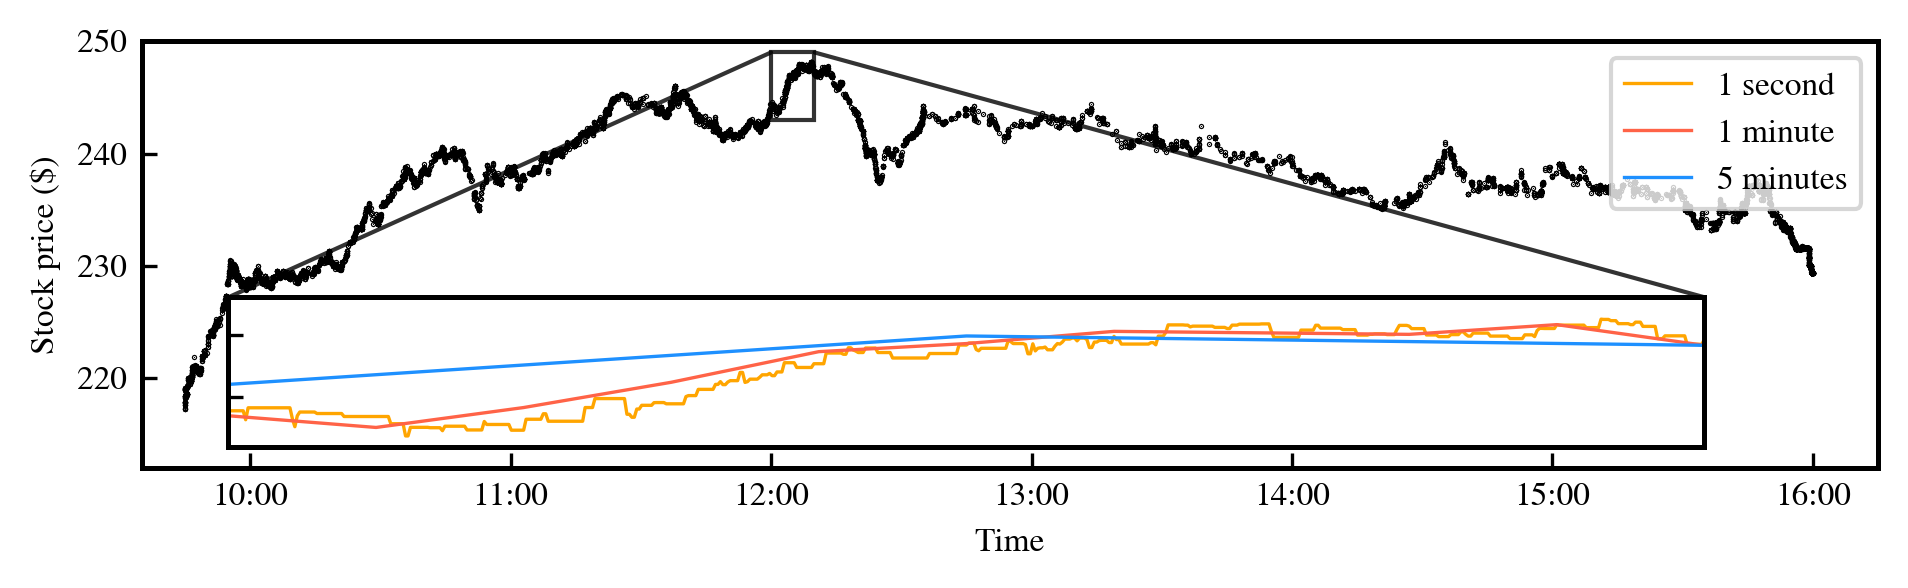

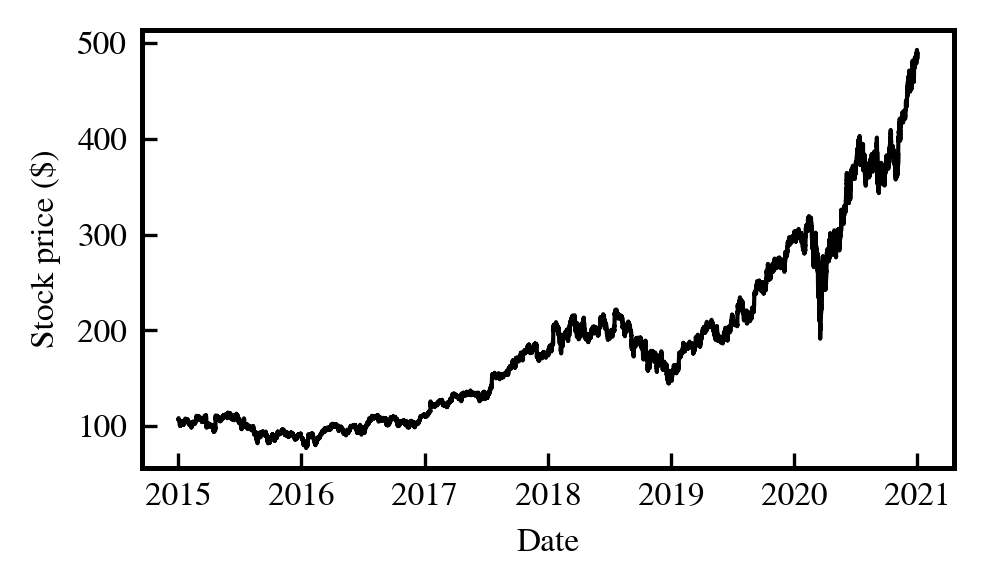

In [12]:
def plot_one_day():
    fig,ax = plt.subplots(figsize=(6.4,2))
    ax.scatter(df_highres_covid.index, df_highres_covid.PRICE,s=0.08,color='black')
    
    xformatter = mdates.DateFormatter('%H:%M')
    plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
    plt.xlabel('Time')
    #plt.yticks(np.arange(135,149,3))
    plt.ylim(212,250)
    plt.ylabel('Stock price ($)')
    
    plt.xlim(datetime.datetime(2020,3,16,9,35,0),datetime.datetime(2020,3,16,16,15,0))
    axins = ax.inset_axes([0.05, 0.05, 0.85, 0.35])
    corona_peak1_min = df_highres_covid.resample('1T')[['PRICE']].median().fillna(method='ffill')
    corona_peak5_min = df_highres_covid.resample('5T')[['PRICE']].median().fillna(method='ffill')
    corona_peak1_sec = df_highres_covid.resample('1s')[['PRICE']].median().fillna(method='ffill')
    
    axins.plot(corona_peak1_sec.index, corona_peak1_sec,lw=0.8,color='orange',label = '1 second')
    #axins.plot(corona_peak1_sec.index, corona_peak1_sec,lw=0.8,color='orange',label='1 second')
    axins.plot(corona_peak1_min.index, corona_peak1_min,lw=0.8,color='tomato',label='1 minute')
    axins.plot(corona_peak5_min.index, corona_peak5_min,lw=0.8,color='dodgerblue',label='5 minutes')
    
    
    
    # sub region of the original image
    x1 = datetime.datetime(2020,3,16,12,0,0)
    x2 = datetime.datetime(2020,3,16,12,10,0)
    y1, y2 = 243,249#144.7,146.8
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticks([])
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    #axins.tick_params(axis="y",direction='in',pad=-35)

    #axins.set_yticks([0.5,0.55])
    axins.set_yticklabels('')
    ax.indicate_inset_zoom(axins,lw=1,alpha=0.8,edgecolor='black',label='')
    handles, labels = axins.get_legend_handles_labels()
    ax.legend(handles, labels,loc='upper right',frameon=1)
    plt.tight_layout()
    plt.savefig('ASML_intraday.pdf',bbox_inches='tight')
    
    plt.show()
def plot_all():
    plt.figure(figsize=(3.321,2))
    plt.plot(df.index, df.PRICE,color='black',lw=1)
    
    plt.xlabel('Date')
    plt.ylabel('Stock price ($)')
    plt.tight_layout()
    plt.savefig('ASML_6years.pdf',bbox_inches='tight')
    plt.show()
plot_one_day()
plot_all()

In [10]:
class realized_kernel():
    def __init__(self):
        """Initialize, call some functions"""
        self.make_time_index()
        return

    def make_time_index(self):
        """We want the data to be restructured onto a regular 1 sec grid 
           to obtain the sparse estimates. Therefore we built a list of 1sec
           times"""
        # Define time arr for every second
        times = []
        for hours in range(9,16):
            for minutes in range(0,60):
                for seconds in np.arange(0,60,1):
                    h = str(hours) if hours>=10 else '0'+str(hours)
                    m = str(minutes) if minutes>=10 else '0'+str(minutes)
                    s = str(seconds) if seconds>=10 else '0'+str(seconds)
                    times.append(h+':'+m+':'+s)
        #times = times[60:]
        self.times = times[1800:]
        
    def make_regular_df(self,onedaydf):
        """Make 1 sec regular dataframe from irregular one day dataframe of prices.
           Note, irregular_day_df should be a 1-day only dataframe with prices
           (no sizes here). If there is no trade, we take the previous time"""
        # Extract times from datetimes
        onedaydf['logprice'] = np.log(onedaydf.PRICE)
        # Get deltalog and deltalog^2 prices
        onedaydf['deltalog'] = onedaydf.logprice.diff()*100
        onedaydf['deltalog2'] = (onedaydf['deltalog'])**2
        
        regular_df = onedaydf.resample('1S')[['PRICE']].median().fillna(method='ffill')
        regular_df['logprice'] = np.log(regular_df.PRICE)
        # Get deltalog and deltalog^2 prices
        regular_df['deltalog'] = regular_df.logprice.diff()*100
        regular_df['deltalog2'] = (regular_df['deltalog'])**2
        
        return regular_df, onedaydf
        
    
    def get_sparse_IV(self,df):
        """Make 1 minute interpolated dataframe"""
        IV_sparse= []
        for i in range(0,22200):
            ds = datetime.timedelta(seconds=i)
            sec_df = df.loc[df.index[0]+ds:df.index[0]+datetime.timedelta(minutes=20)+ds]
            IV_sparse.append(sec_df['deltalog2'].sum()*6.5*3)
        IV_sparse =np.median(IV_sparse)
        return IV_sparse
        
    
    def get_RV_sparse(self,input_logprices):
        """Obtain estimate for RVsparse using the 1-sec interpolated logprices"""
        offsets = np.arange(1200)
        RVs =  np.zeros(1200) # 20min sets
        for offset in offsets:
            # built array (ie 0,1200,2400, etc)
            tochoose = np.arange(0+offset,len(input_logprices),1200)
            # select each 1200th element (plus offset)
            logprices = input_logprices.iloc[tochoose].values.flatten()
            diffs = np.diff(logprices)*100
            RV = np.sum(diffs**2)
            RVs[offset] = RV
        return np.mean(RVs)
    
    
    def RV_dense(self,input_logprices):
        """Get estimate for the dense RV using all irregular spaced returns"""
        q = 25
        offsets = np.arange(q)
        RVs = np.zeros(q)
        Ns  = np.zeros(q)
        for offset in offsets:
            tochoose = np.arange(0+offset,len(input_logprices),q)
            logprices = input_logprices.iloc[tochoose].values.flatten()
            diffs = np.diff(logprices)*100
            RV = np.sum(diffs**2)
            RVs[offset] = RV
            Ns[offset]  = (diffs>0).sum()
        return RVs,Ns
    
    def get_omega(self,df_irregular):
        """Get estimate for omega^2 hat"""
        # collect RVdense estimates
        RVdenses,Ns = self.RV_dense(df_irregular[['logprice']])
        omega2hat_i = RVdenses / (2*Ns)
        omega2hat = np.mean(omega2hat_i)
        return omega2hat
    
    
    def get_optimal_bandwidth(self,regular_df,irregular_df):
        # get estimate for sparse RV
        rvsparse = self.get_RV_sparse(regular_df[['logprice']])
        # Get omega
        omega2hat = self.get_omega(irregular_df)
        xi2 = omega2hat / rvsparse
        xi = np.sqrt(xi2)
        H =  int(3.5134*len(irregular_df)**(3/5)*xi**(4/5))
        return H
    
    
    def Parzen(self,x):
        """Return Parzen kernel for x"""
        if 0<=np.abs(x)<=1/2:
            return 1-6*np.abs(x)**2+6*np.abs(x)**3
        elif 1/2<=np.abs(x)<=1:
            return 2*(1-np.abs(x))**3
        elif np.abs(x)>1:
            return 0
        
    def obtain_K(self,H,irregular_df):
        # make array to loop from -H to H
        h_arr = np.arange(-H,H+1,1,dtype=int)
        irregular_df['deltalog'] = np.log(irregular_df.PRICE).diff().values*100
        # make flat numpy array from the raw return data (approx second)
        x = irregular_df.deltalog.dropna().values.flatten()
        #x = x[np.abs(x)>0]

        K_X = 0
        parzen_values=[]
        # loop 1 over the lags
        gamma1 = 0
        for h in h_arr:
            j_arr = np.arange(np.abs(h)+1,len(x)+1,dtype=int)
            gamma_h = 0
            # loop two for the autocovariances
            for j in j_arr:
                gamma_h += x[j-1]*x[j-np.abs(h)-1]
            K_X += gamma_h*self.Parzen(h/(H+1))
            if h==1:
                gamma1 = gamma_h
        return K_X,gamma1
    
    def worker(self,day,H=None,get_H=False,ret_gamma1=False):
        """worker to loop over days"""
        try:
            daily_counts = pd.read_hdf('./days.h5')
            counts = daily_counts.loc[day].iloc[0]
            # to be faster: find where we are approximately
            iloc0 = max(int(daily_counts.loc[:day].sum().iloc[0]-counts)-10000,0)
            hdf_df = pd.read_hdf('./data.h5')
            
            oneday = hdf_df.iloc[iloc0:counts+iloc0+10000].loc[day]
            # get regular and irregular dfs
            regular_df, irregular_df = self.make_regular_df(oneday)
            # make sparse (1min) df
            #prse_oneday = self.make_sparse_df(oneday)
            #print(prse_oneday)
            # get RVsparse
            RVsparse = self.get_RV_sparse(regular_df[['logprice']])
            
            # get optimal bandwidth
            Hopt = self.get_optimal_bandwidth(regular_df, irregular_df)
            # get realized kernel estimate 
            if not H:
                H = Hopt
                print('Hopt',Hopt)
            else:
                H = H
            RK_est,gamma1 = self.obtain_K(H,irregular_df)
            print(day,'success')
            if ret_gamma1:
                return RK_est,gamma1
            if get_H:
                return RK_est,H
            else:
                return RK_est
        except:
            print(day,'failed')
            return np.nan
    def iterate_over_days(self):
        # Get unique days in dataset
        daily_counts = pd.read_hdf('./days.h5')
        df = pd.read_hdf('data.h5')
        days = daily_counts.index[(daily_counts>0).values.flatten()]
        days = [w.strftime('%Y-%m-%d') for w in days]
        # iterate over days
        RK_estimates = Parallel(n_jobs=23)(delayed(self.worker)(i,get_H=False,ret_gamma1=True) for i in days)
        RKs = np.array([w[0] for w in RK_estimates])
        gamma_1s = np.array([w[1] for w in RK_estimates])
        print(gamma_1s)
        #np.array([self.worker(day) for day in days[:N]])#
        self.RKvalues = pd.DataFrame({'Day':days,'RealizedKernel':RKs})
        return self.RKvalues,gamma_1s

    def signature_plot(self,day):
        Hs = np.hstack((np.logspace(0.1,2.5,80,dtype=int),[None]))
        
        #K_Hs = [self.worker(day,H,False,True) for H in Hs]
        K_Hs = Parallel(n_jobs=23)(delayed(self.worker)(day,H,True,False) for H in Hs)
        Ks = np.array([w[0] for w in K_Hs])
        gamma1s = np.array([w[1] for w in K_Hs])

        plt.figure()
        plt.ylabel('IV estimate')

        plt.plot(Hs,Ks,color='dodgerblue',label='Realized Kernel',lw=1,zorder=1)
        #plt.scatter(H_opt,obtain_K(H_opt),color='red',s=2)
        
        
        daily_counts = pd.read_hdf('./days.h5')
        counts = daily_counts.loc[day].iloc[0]
        # to be faster: find where we are approximately
        iloc0 = max(int(daily_counts.loc[:day].sum().iloc[0]-counts)-1000,0)
        hdf_df = pd.read_hdf('./data.h5')
        oneday = hdf_df.iloc[iloc0:counts+iloc0+1000].loc[day]
        
        
        #regular_df, irregular_df = self.make_regular_df(oneday)
        #sparse_IV = self.get_sparse_IV(regular_df)
        sparse_IV = ((np.log(df.loc[day].resample('1T')[['PRICE']].median()).diff()*100)**2).sum().iloc[0]
        plt.axhline(sparse_IV,color='tomato',lw=0.7,label='Sparse volatility')
        plt.xlabel('Bandwidth')
        #plt.ylim(13,26)
        
        plt.scatter(K_Hs[-1][1],K_Hs[-1][0],label=r'$H^*$',color='orange',s=8,zorder=2)
        plt.legend(frameon=1,loc='upper right')
        plt.tight_layout()
        plt.savefig('vola_vs_bandwidth.pdf')
        plt.show()

    def plot_RKvol(self):
        RK_values = self.RKvalues
        ### plot figure
        RK_values.index = pd.to_datetime(RK_values.Day)
        df_1min = df[['PRICE']].resample('1T').median()
        df_1min['logprice'] = np.log(df_1min.PRICE)
        df_1min['deltalog'] = df_1min.logprice.diff()*100
        df_1min['deltalog2'] = (df_1min.logprice.diff()*100)**2
        sparse_volas = np.sqrt(252*df_1min.deltalog2.resample('1D').sum())
        plt.plot(RK_values.index,RK_values.RealizedKernel,lw=1,label='RKVOL')
        plt.plot(sparse_volas[sparse_volas>0],lw=1,label='RVOL')
        plt.legend(frameon=1)
        plt.ylabel('Annualized volatility [%]')


RK = realized_kernel()
#RK.signature_plot('2017-05-26')

In [11]:
RK_values,gamma_1s = RK.iterate_over_days()
RK_values = RK_values.set_index('Day')
RK_values.index = pd.to_datetime(RK_values.index)

[ 0.02059994 -0.02654572  0.03806595 ... -0.22748042 -0.09813863
 -0.15306988]


In [ ]:
RK_values.to_pickle('./asml_RK.pickle')

In [8]:
RK_values = pd.read_pickle('./asml_RK.pickle')

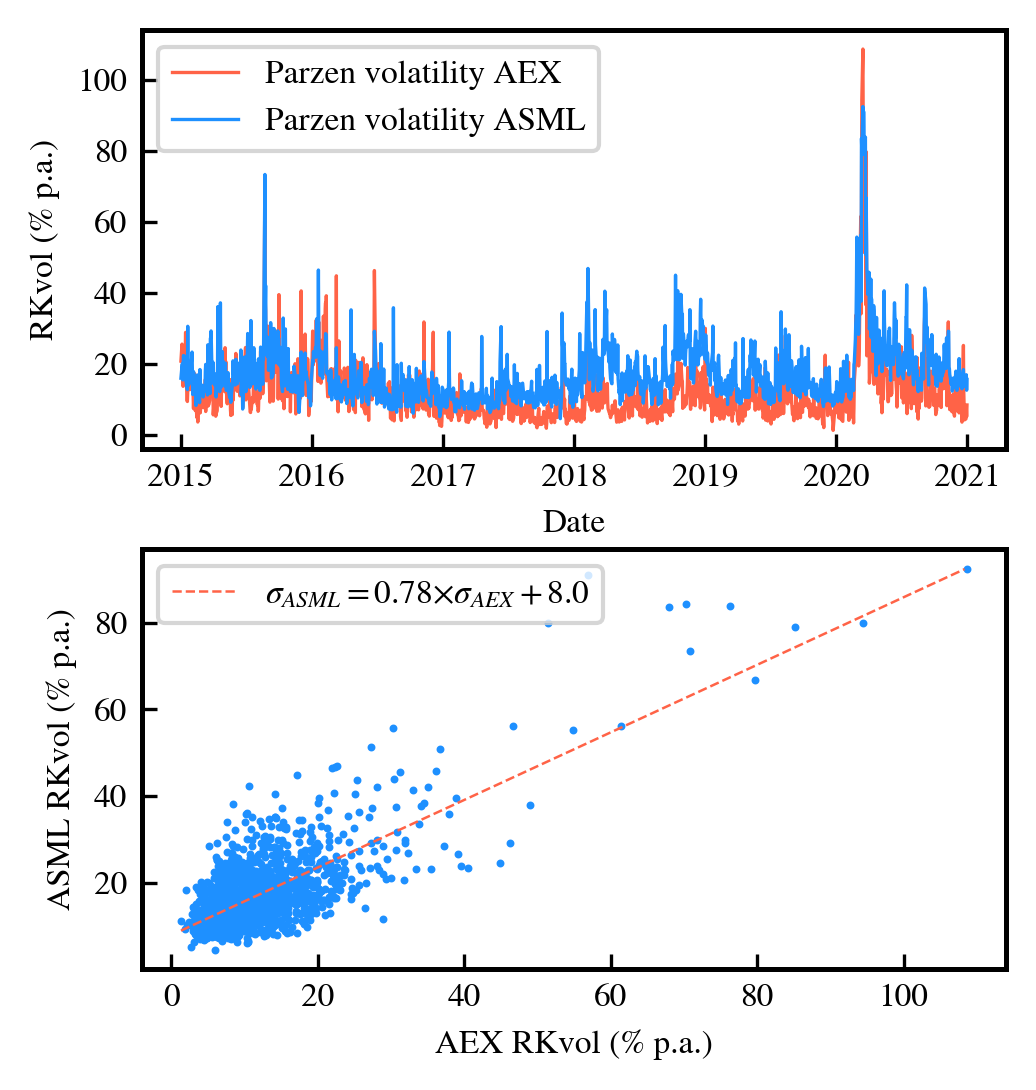

In [13]:
def plot_RK_ASML_vs_index():
    data = pd.read_csv('oxfordmanrealizedvolatilityindices.csv')
    #get S&P500 index
    SP = data.loc[data['Symbol'] == '.AEX'] #.AEX
    SP = SP.rename(columns = {'Unnamed: 0': 'DATETIME'})
    SP = SP.loc[SP['DATETIME'] >= '2015-01-02 00:00:00+00:00']
    SP = SP.loc[SP['DATETIME'] <= '2020-12-31 00:00:00+00:00']

    SP = SP.set_index('DATETIME')
    SP.index = pd.to_datetime(SP.index)
    SP.index = pd.to_datetime([w.strftime('%Y-%m-%d') for w in SP.index])

    parzen_SP500 =np.sqrt(252*1e4*SP[['rk_parzen']])
    parzen_ASML = np.sqrt(252*RK_values)
    fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(3.321,3.5))
    ax1.plot(parzen_SP500,color='tomato',label='Parzen volatility AEX', linewidth = 0.8)
    ax1.plot(np.sqrt(252*RK_values), color = 'dodgerblue', label = "Parzen volatility ASML", linewidth = 0.8)
    ax1.legend(frameon = 1, loc = 'upper left')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RKvol (% p.a.)')

    SP_ASML_joined = pd.merge(parzen_ASML,parzen_SP500,left_index=True,right_index=True)
    ax2.scatter(SP_ASML_joined.rk_parzen,SP_ASML_joined.RealizedKernel,s=0.8,color = 'dodgerblue')
    yfit = np.polyfit(SP_ASML_joined.rk_parzen,SP_ASML_joined.RealizedKernel,1)
    xnew = np.arange(SP_ASML_joined.rk_parzen.min(),SP_ASML_joined.rk_parzen.max())
    label=r'$\sigma_{ASML}=$' + str(np.round(yfit[0],2)) + r'$\times \sigma_{AEX}+$' + str(np.round(yfit[1],2))
    ax2.plot(xnew,yfit[0]*xnew+yfit[1],ls='--',color='tomato',lw=0.6,label=label)
    ax2.set_xlabel('AEX RKvol (% p.a.)')
    ax2.set_ylabel('ASML RKvol (% p.a.)')
    ax2.legend(frameon=1,loc='upper left')
    plt.tight_layout(pad=0.3)
    plt.savefig('index_vs_ASML.pdf',bbox_inches='tight')
plot_RK_ASML_vs_index()

In [102]:
def SPvsASML():
    #Get daily returns of S&P500 
    closingprices_sp = SP[['close_price']].groupby(SP.index).apply(lambda x: x.iloc[[-1]])
    closingprices_sp.index = closingprices_sp.index.droplevel(0)
    daily_returns_sp = np.log(closingprices_sp).diff().iloc[1:]

    #Make date index s.t. we can match S&P500 with ASML
    daily_returns.set_index(daily_returns['date'], drop=True, append=False, inplace=True, verify_integrity=False)

    daily_returns_sp.index = pd.to_datetime(daily_returns_sp.index, utc=True)
    daily_returns_sp['date'] = daily_returns_sp.index.date
    daily_returns_sp.set_index(daily_returns_sp['date'], drop=True, append=False, inplace=True, verify_integrity=False)

    daily_returns_sp = daily_returns_sp.rename(columns = {'close_price': 'return'})

    daily_returns.drop(columns = ['date'])

SPvsASML()

KeyError: 'date'

In [101]:
#merge data st we can make scatter plot
merged_df = daily_returns.merge(daily_returns_sp, how='inner', on=None, right_index=True, left_index=True, sort=False)
#Plot scatter of S&P500 returns vs ASML returns
plt.scatter(merged_df['PRICE'], merged_df['return'], s = 0.08)
plt.title("Daily returns - S&P500 & ASML")

NameError: name 'daily_returns_sp' is not defined

In [15]:
RK_values.index = pd.to_datetime(RK_values.index)

In [ ]:
def RV(samplefreq):
    # Resample to given frequency
    resampled = df.resample(samplefreq).PRICE.median().dropna()
    resampled['LOGPRICE'] = np.log(resampled)
    resampled['DELTALOG'] = resampled['LOGPRICE'].diff()*100
    resampled['DELTALOG2'] = resampled['DELTALOG']**2
    
    # Obtain RV
    RV = resampled['DELTALOG2'].resample('1D').sum()
    # Obtain RVOL
    return RV
    RVOL = np.sqrt(RV*252)
    RVOL = RVOL[RVOL>0]
    return RVOL

In [ ]:
RVOL_30s = RV('30S')
RVOL_5min =  RV('5T')
RVOL_60min =  RV('60T')

In [ ]:
RVOL_60min.index = [w.strftime('%Y-%m-%d') for w in RVOL_60min.index]
RVOL_60min = pd.DataFrame(RVOL_60min)
RVOL_60min.columns = ['RV']

In [ ]:
a=daily_returns.copy()#join(RVOL_60min)
a.index = [w.strftime('%Y-%m-%d') for w in a.index]

In [ ]:
b = a.join(RVOL_60min).reset_index()[['PRICE','RV']]

In [ ]:
b.columns = ['return','RV']

In [ ]:
b['return']=1/100*b['return']

In [ ]:
b['logRV'] = np.log(b.RV)

In [ ]:
b.to_csv('dailyreturns_RVOL.csv')

In [134]:
def compare_RV_RK():
    #RVOL_1s = RV('1S')
    RK = np.sqrt(252*RK_values.RealizedKernel)
    fig,ax = plt.subplots()
    #plt.plot(RVOL_1s.index,RVOL_1s.values,lw=0.6,label='RVOL 1 sec')
    plt.plot(RVOL_30s.index,RVOL_30s.values,lw=1,label='RVOL 30 sec',color='dodgerblue',alpha=0.84)
    plt.plot(RVOL_5min.index,RVOL_5min.values,lw=1,label='RVOL 5 min',color='tomato',alpha=0.84)
    plt.plot(RVOL_60min.index,RVOL_60min.values,lw=1,label='RVOL 60 min',color='green',alpha=0.84)
    plt.plot(RK_values.index, RK,lw=1,label='Realized Kernel',color='black')
    plt.legend(frameon=1,loc='upper left')
    plt.tight_layout()
    plt.xlim([datetime.date(2018, 6, 1), datetime.date(2020, 12, 1)])
    plt.ylabel('Annualized volatility [%]')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.savefig('RVOL_vs_RK.pdf',bbox_inches='tight')
    plt.show()
compare_RV_RK()

<ipython-input-27-a2162b2af6da>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LOGPRICE'] = np.log(df.PRICE)
<ipython-input-27-a2162b2af6da>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DELTALOG'] = (df.LOGPRICE.diff()*100)
/Applications/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

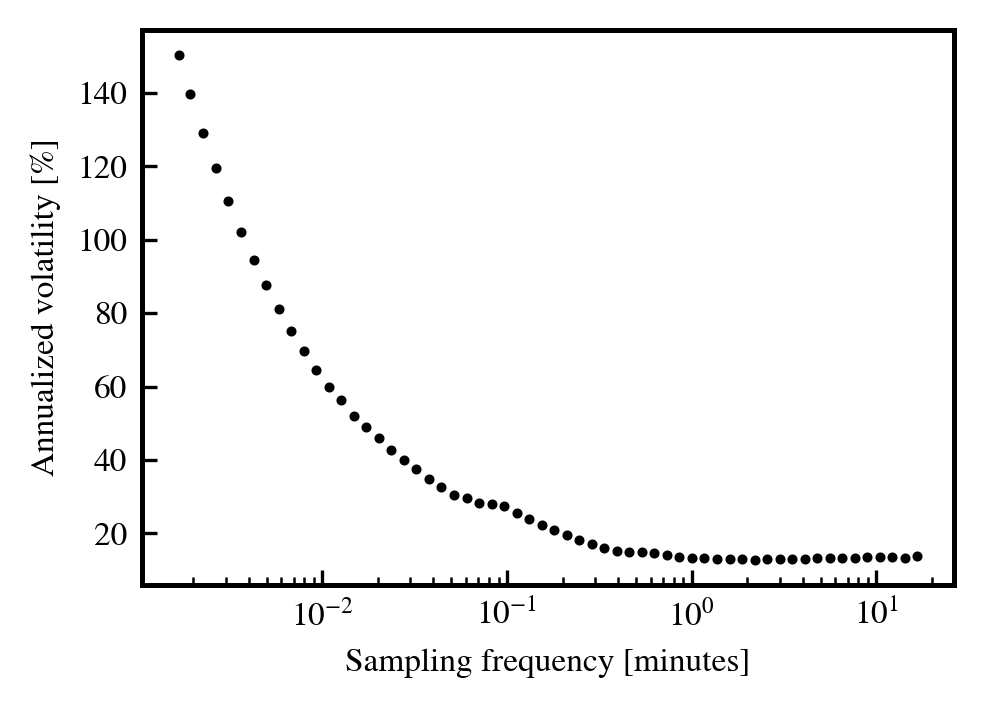

In [27]:
class signature_plot():
    def __init__(self):
        # Get df with deltalog returns
        self.length = 100000
        self.__prep_df__(df[:self.length])
        self.__obtain_RVs__()
        return
    
    def __prep_df__(self,df):
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = (df.LOGPRICE.diff()*100)
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        self.df = df[['DELTALOG']]
        
    def __worker__(self,dT):
        RVs = (self.df[:self.length].DELTALOG**2).resample(str(dT)+'ms').sum()
        RVOL = np.sqrt(np.median(RVs[RVs>0]))
        RVOL = RVOL * np.sqrt(252) * np.sqrt(6.5*3600*1000/dT)
        return RVOL
    
    def __obtain_RVs__(self):
        N = 60
        dT_array = np.logspace(2,6,N,dtype=int)
        RVOLs = Parallel(n_jobs=2)(delayed(self.__worker__)(dT) for dT in dT_array)
        self.dT = dT_array
        self.RVOLs = RVOLs
        
    def __plot__(self):
        plt.figure(figsize=(3.321,2.4))
        plt.scatter(self.dT/60000, self.RVOLs,color='black',s=2)
        plt.semilogx()
        plt.xlabel('Sampling frequency [minutes]')
        plt.ylabel('Annualized volatility [%]')
        plt.tight_layout()
        plt.savefig('signature_plot.pdf',bbox_inches='tight')
        plt.show()
        
sigplotter = signature_plot()
sigplotter.__plot__()

mean: 0.10014494220969888 skew: -0.645342552220145 kurtosis: 7.872997901937509


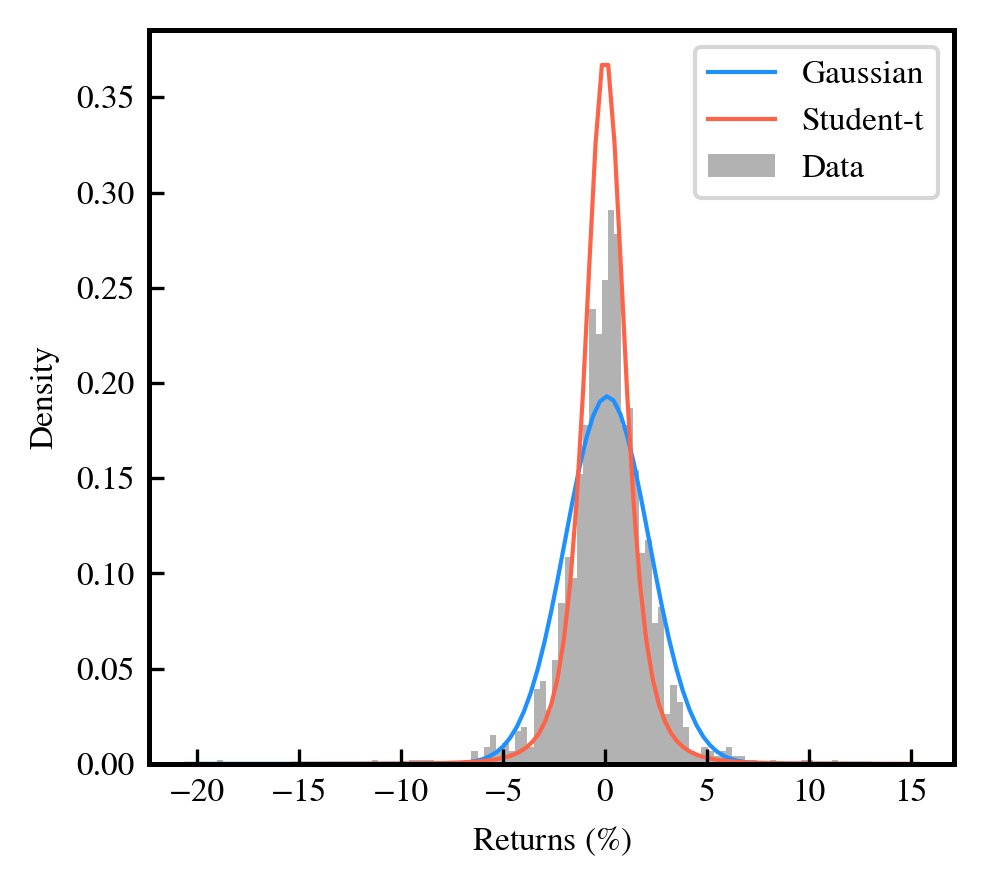

In [9]:
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import t

def return_dist(closingreturns):
    mu_data = np.mean(closingreturns)
    std_data = np.std(closingreturns)
    skew_data = stats.skew(closingreturns)
    kurt_data = stats.kurtosis(closingreturns)

    # Fit a normal distribution to the data
    mu, std = norm.fit(closingreturns)
    p = norm.pdf(closingreturns, mu, std)

    # Fit a t-distribution to the data
    df = t.fit(closingreturns)[0]
    mean, var, skew, kurt = t.stats(df, moments='mvsk')
    
    fig, ax = plt.subplots(1, 1)
    # Plot histogram
    plt.hist(closingreturns, bins=100, density=True, color='black', alpha=0.3, label='Data')

    # Plot the normal PDF
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=1, label='Gaussian', color='dodgerblue')

    # Plot the t PDF
    x = np.linspace(t.ppf(0.0001, df), t.ppf(0.9999, df), 100)
    plt.plot(x, t.pdf(x, df), alpha=1, label='Student-t', color='tomato', lw='1')

    plt.xlabel('Returns ($\%$)')
    plt.ylabel('Density')
    plt.legend(frameon=1)
    plt.tight_layout()
    plt.savefig('Return_distribution.pdf',bbox_inches='tight')
    print('mean:', mu_data, 'skew:', skew_data, 'kurtosis:', kurt_data)
    
returns_daily = daily_returns.values.flatten()*100
return_dist(returns_daily)

In [8]:
daily_returns.to_hdf('daily_returns.h5', key='df', mode='w')

In [17]:
pd.read_hdf('daily_returns.h5')['2015':'2018;12;29']

,PRICE
DATETIME,
2015-01-05 15:59:59.920000000,-0.033719
2015-01-06 15:59:59.923000000,-0.029821
2015-01-07 15:59:58.049000000,0.004950
2015-01-08 15:59:57.777000000,0.021010
2015-01-09 15:59:57.752000000,-0.013337
...,...
2018-12-21 15:59:59.973435299,-0.028031
2018-12-24 13:51:29.789667374,-0.023514
2018-12-26 15:59:59.997397122,0.052462


In [ ]:
RK

In [354]:
from scipy.optimize import minimize
class estimate_GARCH():
    def __init__(self,model,p,q,maxdate=None):# or 'RealGARCH'
        self.options = {'eps':1e-09,
                        'maxiter':2000}
                        
        self.p,self.q = p,q
        self.model = model # 'RealGARCH'
        # store the maxdata parameter for if we do predictions
        self.maxdate = maxdate
        if not maxdate:
            df = pd.read_hdf('daily_returns.h5')
            self.datetimes = df.index
            self.closingreturns = df.values.flatten()*100
        else: 
            df = pd.read_hdf('daily_returns.h5')['2015':self.maxdate]
            self.datetimes = df.index
            self.closingreturns = df.values.flatten()*100
        self.__RVOL__()
        # Call fit of GARCH
        self.fit_garch(self.closingreturns)
        return
    
    def __RVOL__(self):
        """Obtain realized volatilities from highfreq data"""
        # Convert to logprices
        """df = pd.read_hdf('data.h5')
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = df.LOGPRICE.diff()*100
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        # Take sum of squared returns within one day and resample to annual volatility
        self.RVOL = np.sqrt((df[['DELTALOG']]**2).resample('1D').sum())
        self.RVOL = self.RVOL[self.RVOL>0]
        # Daily returns do not have first day and no weekends, so drop them
        self.RVOL = self.RVOL.dropna().values.flatten()[1:]"""
        
        self.RVOL = RK_values
        if self.maxdate:
            self.RVOL = self.RVOL['2015':self.maxdate]
        self.RVOL = self.RVOL.values.flatten()[1:]
    
    def __one_step__(self):
        # Obtain historical sigmas (on which the model was trained)
        # and obtain past returns
        _,conditional_sigma = self.return_vola()
        x = self.closingreturns
        # Get fitted parameters
        params = self.estimates
        omega = np.exp(params[0])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.exp(params[i+1])/(1+np.exp(params[i+1]))
        for i in range(0,self.p):
            betas[i] = np.exp(params[i+self.q+1])/(1+np.exp(params[i+self.q+1]))
        # Predict one new value
        alpha_part = 0
        beta_part  = 0
        # Obtain beta part (lagged sigma2)
        t = len(conditional_sigma)
        for i in range(0,self.p):
            beta = betas[i]
            beta_part = beta_part+beta*conditional_sigma[t-i-1]
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = alphas[i]
                if self.model == 'GARCH':
                    alpha_part = alpha_part+alpha*x[t-i-1]**2
                if self.model == 'RealGARCH':
                    alpha_part = alpha_part+alpha*self.RVOL[t-i-1]**2
            # Combine in sigma2[t]
            sigma_future = omega + alpha_part + beta_part
        return sigma_future
    
    
    
    
    def __llik_fun_GARCH__(self,params,estimate=True):
        x = self.closingreturns
        n = len(x)
        # Convert parameters back from their log normalization
        omega = np.exp(params[0])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.exp(params[i+1])/(1+np.exp(params[i+1]))
        for i in range(0,self.p):
            betas[i] = np.exp(params[i+self.q+1])/(1+np.exp(params[i+self.q+1]))
        
        # Iterate through sigma2 using the GARCH updating rules
        sigma2 = np.zeros(n)
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            sigma2[i] = np.var(x)
        # Iterate through times
        for t in range(max(self.p,self.q),n):
            alpha_part = 0
            beta_part  = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                beta = betas[i]
                beta_part = beta_part+beta*sigma2[t-i-1]
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                alpha = alphas[i]
                
                if self.model == 'GARCH':
                    alpha_part = alpha_part+alpha*x[t-i-1]**2
                if self.model == 'RealGARCH':
                    alpha_part = alpha_part+alpha*self.RVOL[t-i-1]**2
            # Combine in sigma2[t]
            sigma2[t] = omega + alpha_part + beta_part
        
        
        # Derive likelihood
        if estimate:
            L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2

            llik = np.mean(L)

            return -1*llik
        else:
            return sigma2
    
    
    def fit_garch(self,x):
        # Initialize values
        b = np.ones(self.p)*(0.4/self.p)  # initial value for beta
        a = np.ones(self.q)*(0.1/self.q) # initial value for alpha
        omega = np.nanvar(self.closingreturns)*(1-np.sum(a)-np.sum(b)) # initial value for omega
        
        par_ini = np.array([omega])#np.array([np.log(omega)])
        
        alphas = np.zeros(self.q)
        betas  = np.zeros(self.p)
        
        for i in range(0,self.q):
            alphas[i] = np.log(a[i]/(1-a[i]))
        for i in range(0,self.p):
            betas[i] = np.log(b[i]/(1-b[i]))
        
        par_ini = np.hstack((par_ini,alphas, betas))
        
        est = minimize(self.__llik_fun_GARCH__, x0=par_ini,
                       options = self.options,
                       method = 'L-BFGS-B'
                       #bounds = ((0.0001, 100), (0, 10), (0,1))
                      )
        llikhood = -est.fun
        self.AIC = 2*(len(par_ini))-2*llikhood
        self.BIC = (len(par_ini)) * np.log(len(self.closingreturns)) - 2*llikhood
        self.llik_opt = llikhood
        
        self.estimates = est.x
        omega_hat = np.exp(self.estimates[0])
        
        betas = np.array([np.exp(w)/(1+np.exp(w)) for w in self.estimates[1:self.p+1]])
        alphas = np.array([np.exp(w)/(1+np.exp(w)) for w in self.estimates[1+self.p:]])
        
        self.thetahat = np.hstack((omega_hat,alphas,betas))
        
        
    def return_vola(self):
        sigma2 = self.__llik_fun_GARCH__(self.estimates,estimate=False)
        return self.datetimes,sigma2
    
    def return_llik_AIC_BIC(self):
        return self.AIC,self.llik_opt


,AIC,llikhood
"GARCH(1, 1)",10.081747,-2.040874
"GARCH(1, 2)",12.081609,-2.040804
"GARCH(1, 3)",14.081232,-2.040616
"GARCH(2, 1)",12.080782,-2.040391
"GARCH(2, 2)",14.080782,-2.040391
"GARCH(2, 3)",16.080564,-2.040282
"GARCH(3, 1)",14.078386,-2.039193
"GARCH(3, 2)",16.075556,-2.037778
"GARCH(3, 3)",18.075380,-2.037690
"RealGARCH(1, 1)",10.033868,-2.016934


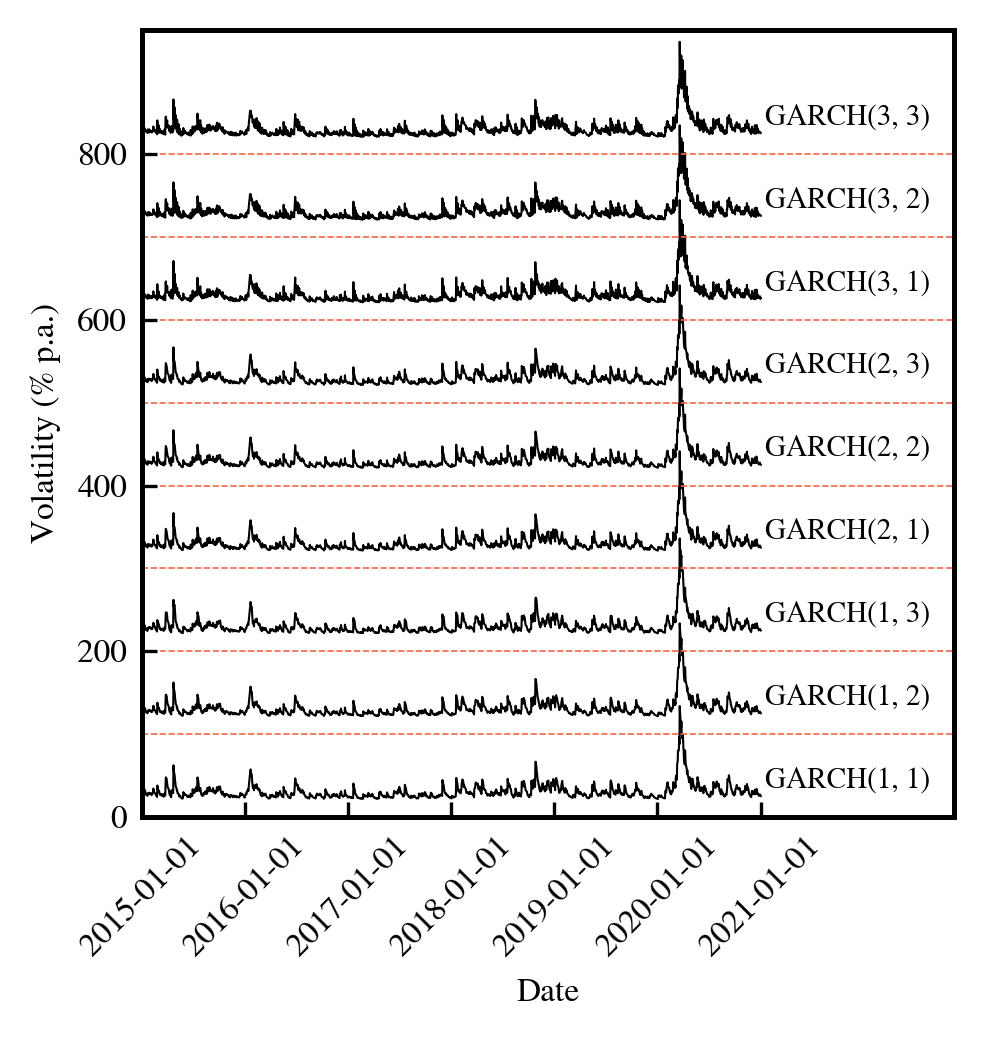

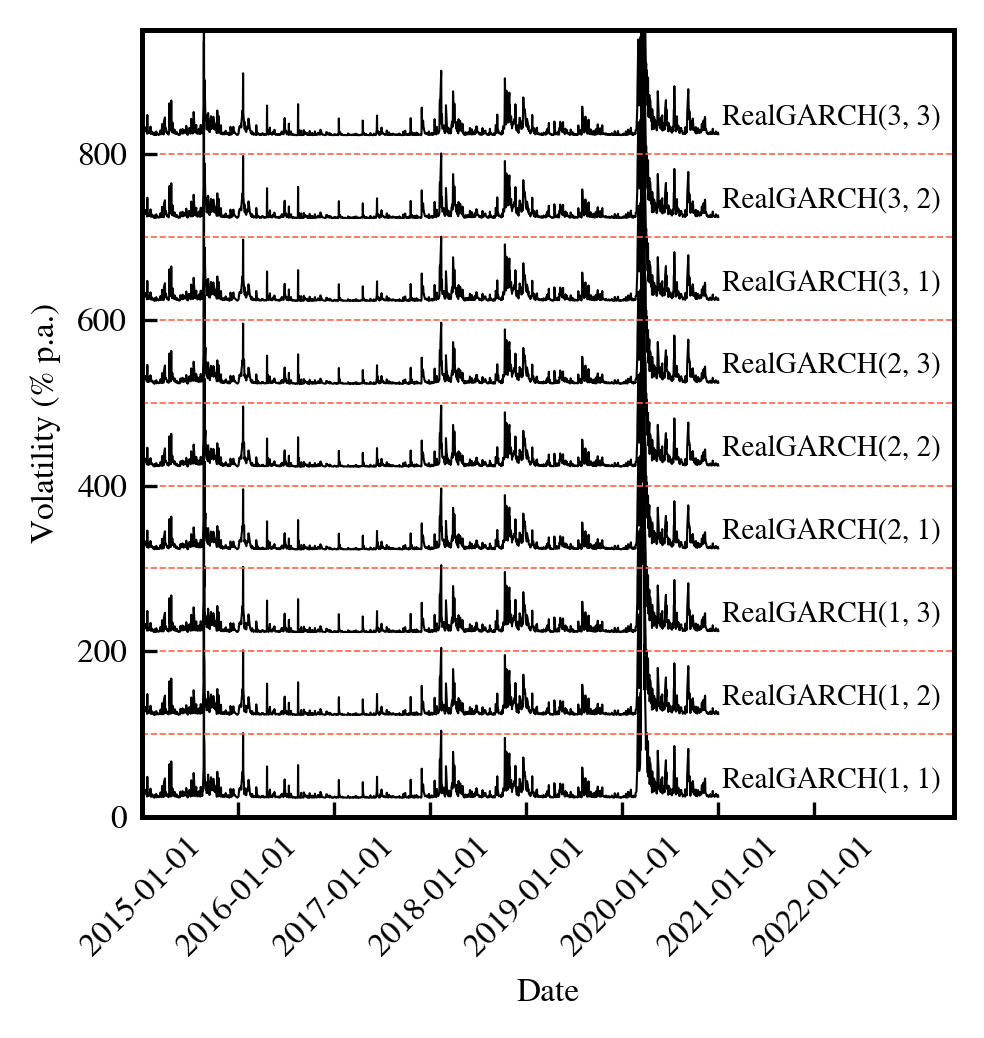

In [355]:
class parallel_GARCH_fitter():
    def __init__(self):
        self.fittedGARCHES,self.garch_AIC_BIC_llikhood=self.simultaneous_fit(modelfamily='GARCH')
        self.fittedRealGARCHES,self.Realgarch_AIC_BIC_llikhood=self.simultaneous_fit(modelfamily='RealGARCH')
        self.concat()
        self.return_vars()
        
    def concat(self):
        self.allGARCH_AIC_llikhood = pd.concat((self.garch_AIC_BIC_llikhood,self.Realgarch_AIC_BIC_llikhood))
        
    def return_vars(self) :
        return self.fittedGARCHES, self.fittedRealGARCHES, self.allGARCH_AIC_llikhood
    
        
    def exists(self,name):
        return (name in sys._getframe(1).f_locals  # caller's locals
             or name in sys._getframe(1).f_globals # caller's globals
             or name in vars(__builtin__)          # built-in
        )

    def simultaneous_fit(self,modelfamily='GARCH'):
        pqpairs = []
        for i in range(1,4):
            for j in range(1,4):
                pqpairs.append((i,j))
        if self.exists('fittedGARCHES') and modelfamily=='GARCH':
            # See if we did this already
            toplot = fittedGARCHES
        elif self.exists('fittedRealGARCHES') and modelfamily=='RealGARCH':
            toplot = fittedRealGARCHES
        else:
            # if not, fit them all simultaneous
            toplot = Parallel(n_jobs=8)(delayed(estimate_GARCH)(model=modelfamily,p=w[0],q=w[1]) for w in pqpairs)
        # Start plotting
        fig,ax=plt.subplots(figsize=(3.321,3.5))
        for i,model in enumerate(toplot):
            x,y = model.return_vola()
            y = np.sqrt(252*y)
            ax.plot(x,y+100*i,lw=0.5,color='black')
            plt.annotate(modelfamily+str(pqpairs[i]),xy=(x[-1]+datetime.timedelta(days=15),y[0]+100*i+3),size=7)
            plt.axhline(100*i,ls='--',lw=0.4,color='tomato')
        deltatime = datetime.datetime(2022,11,16,16,15,0) if modelfamily=='GARCH' else datetime.datetime(2023,6,16,16,15,0)
        ax.set_xlim(datetime.datetime(2015,1,1,9,35,0),deltatime)
        ax.set_xlabel('Date')
        ax.set_ylabel('Volatility (% p.a.)')
        ax.set_ylim(0,950)
        ax.set_xticks(ax.get_xticks()[:-1])
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('all'+modelfamily+'models.pdf',bbox_inches='tight')
        df=pd.DataFrame({'AIC':[],'llikhood':[]})
        for i,model in enumerate(toplot):
            modelname = modelfamily+str(pqpairs[i])
            df.loc[modelname]=model.return_llik_AIC_BIC()
        return toplot,df

fittedGARCHES, fittedRealGARCHES, allGARCH_AIC_llikhood = parallel_GARCH_fitter().return_vars()
allGARCH_AIC_llikhood

In [356]:
# Now predict one step ahead
class GARCH_RealGARCH_predict():
    def __init__(self,modelfamily):
        self.modelfamily = modelfamily
        self.get_pqpairs()
        # Create an array of future dates. We iterate over these days, fit a model and predict the first 
        # next dates volatility
        self.get_dates()
    
        
    def get_pqpairs(self):
        # Get list of all modelsup to (3,3)
        pqpairs = []
        for i in range(1,3):
            for j in range(1,3):
                pqpairs.append((i,j))
        self.pqpairs = pqpairs
        
        
    def simultaneous_fit(self,modelfamily='GARCH',end_day=None):
        N = np.where(np.array(self.end_days) == end_day)[0][0]
        eta = ((time.time() - self.starttime)/(N+1))*len(self.end_days)
        print('Fittig models with dates up to',end_day, 'ETA',np.round(eta,1), ' sec')
        # Get list of all modelsup to (3,3)
        pqpairs = self.pqpairs
        # Fit all models with data up to the end date passed in the function
        estimated_models = [estimate_GARCH(model=modelfamily,p=w[0],q=w[1],maxdate=end_day) for w in pqpairs]
        # Obtain point estimate for future sigma2
        point_ests = np.zeros(len(estimated_models))
        for i,model in enumerate(estimated_models):
            point_ests[i] = model.__one_step__()
        return point_ests
        
    def get_dates(self):
        self.end_days = [w.strftime('%Y-%m-%d') for w in pd.to_datetime(RK_values['2019':].index)]
        
    def sim_fit(self):
        # Make sure total number of jobs is less than 24
        self.starttime = time.time()
        predictions = Parallel(n_jobs=20)(delayed(self.simultaneous_fit)(self.modelfamily,day) for day in self.end_days)
        self.predictions = np.array(predictions)
        return self.predictions

    def evaluate(self):
        # compare predictions with Realized Kernel volatilities
        # Make dataframe to store results
        results_df = pd.DataFrame({'True',})
        acronyms = ['Pred_'+self.modelfamily+str(w) for w in self.pqpairs]
        acronyms = dict(zip(acronyms,[np.array([])]*len(acronyms)))
        acronyms['True']=np.array([])
        acronyms['Date']=np.array([])
        df = pd.DataFrame.from_dict(acronyms)
        df = df.set_index('Date')
        for i in range(len(self.end_days)-1):
            date = pd.Series(RK_values['2019':].index).iloc[i+1].strftime('%Y-%m-%d')
            true = RK_values['2019':].iloc[i+1].values
            prediction = predictions[i]
            df.loc[date] = np.hstack((prediction,true))
        df.index = pd.to_datetime(df.index)
        return df
    
    def get_scores(self):
        # Collect predictions and true
        df = self.evaluate()
        # Convert to annual volas
        df = np.sqrt(252*df)
        # Convert predictions to intraday volas
        for col in df.columns:
            if not col=='True':
                df[col] = df[col] / np.sqrt(24/6.5)
        # Create output df
        score_df = pd.DataFrame({'Model':[],'MAE':[],'RMSE':[]}).set_index('Model')
        # Obtain MAE/RMSE
        for col in df.columns:
            if not col=='True':
                mae = mean_absolute_error(df['True'],df[col])
                rmse = np.sqrt(mean_squared_error(df['True'],df[col]))
                score_df.loc[col] = [mae,rmse]
        return score_df

predictor = GARCH_RealGARCH_predict('RealGARCH')
predictions = predictor.sim_fit()
scores_RealGARCH = predictor.get_scores()

#predictor = GARCH_RealGARCH_predict('GARCH')
#predictions = predictor.sim_fit()
#scores_GARCH = predictor.get_scores()

concat = pd.concat((scores_GARCH,scores_RealGARCH),axis=1)
concat.index = [str(w) for w in 2*predictor.pqpairs]

concat = concat.reset_index().groupby('index').mean()
concat.columns = ['MAE_G','RMSE_G','MAE_RG','RMSE_RG']

print(concat.to_latex())

WorkerInterrupt: 

In [311]:
print(concat.round(2).to_latex(bold_rows=True))

\begin{tabular}{lrrrr}
\toprule
{} &  MAE\_G &  RMSE\_G &  MAE\_RG &  RMSE\_RG \\
\textbf{index } &        &         &         &          \\
\midrule
\textbf{(1, 1)} &   4.96 &    7.97 &    6.34 &    15.54 \\
\textbf{(1, 2)} &   4.96 &    7.97 &    6.34 &    15.49 \\
\textbf{(1, 3)} &   4.98 &    7.92 &    6.35 &    15.47 \\
\textbf{(2, 1)} &   4.90 &    7.58 &    7.65 &    23.25 \\
\textbf{(2, 2)} &   4.89 &    7.58 &    7.65 &    23.24 \\
\textbf{(2, 3)} &   4.89 &    7.57 &    7.66 &    23.32 \\
\textbf{(3, 1)} &   5.55 &    8.63 &    9.74 &    30.41 \\
\textbf{(3, 2)} &   5.37 &    8.18 &    9.74 &    30.39 \\
\textbf{(3, 3)} &   5.38 &    8.19 &    9.74 &    30.40 \\
\bottomrule
\end{tabular}



(0.0, 20.0)

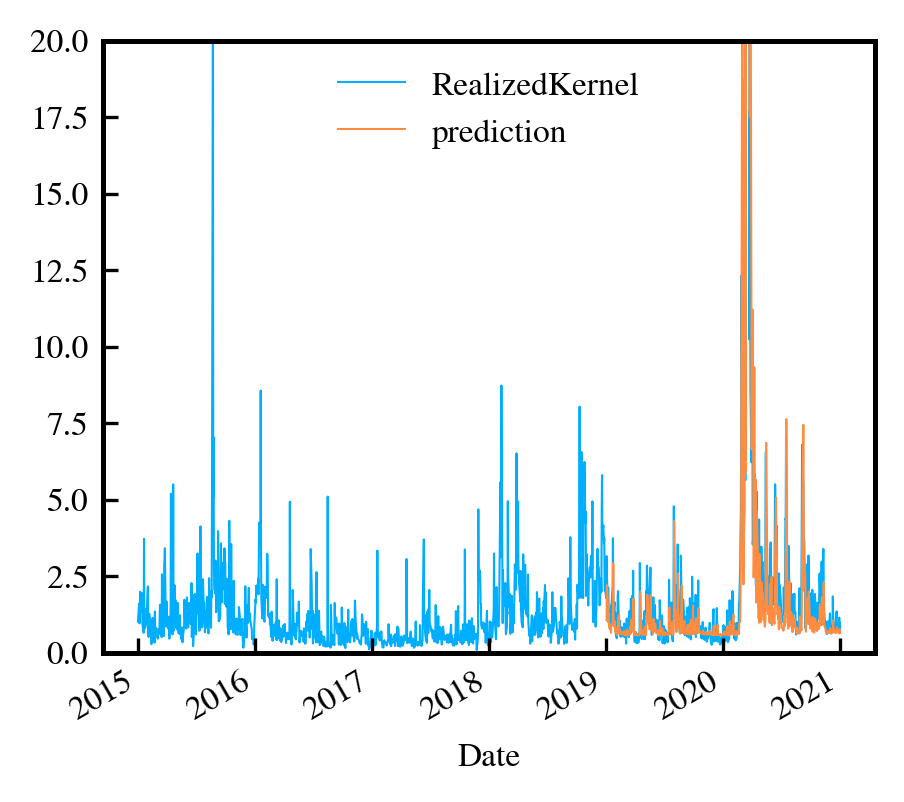

In [282]:
RK_values.plot(lw=0.5)
#plt.plot(*fittedGARCHES[0].return_vola(),lw=0.5,label='garch')
(predictor.evaluate()['Pred_RealGARCH(1, 1)']*6.5/24).plot(lw=0.5,label='prediction')
#(predictor.evaluate()['Pred_GARCH(1, 2)']*6.5/24).plot(lw=0.5,label='prediction')
#(predictor.evaluate()['Pred_GARCH(2, 1)']*6.5/24).plot(lw=0.5,label='prediction')
#(predictor.evaluate()['Pred_GARCH(2, 2)']*6.5/24).plot(lw=0.5,label='prediction')
plt.legend()
plt.ylim(0,20)

Average ratio of realgarch over garch 0.9726996830107509


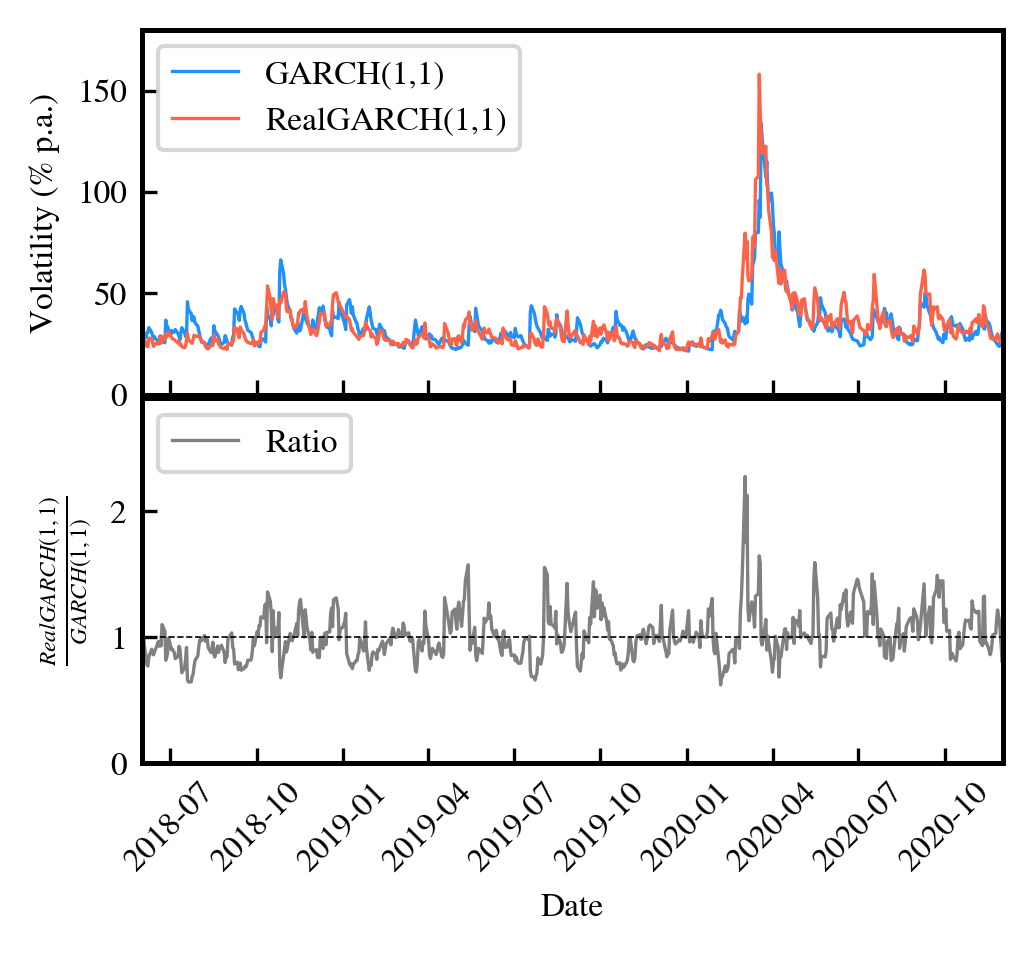

In [313]:
def plot_GARCHestimates():
    GARCH11model = fittedGARCHES[0]
    RGARCH11model = fittedRealGARCHES[0]
    GARCH11x,GARCH11y = GARCH11model.return_vola()
    RGARCH11x,RGARCH11y = RGARCH11model.return_vola()
    
    fig,[ax1,ax2]=plt.subplots(nrows=2)
    ax1.plot(GARCH11x,np.sqrt(252*GARCH11y),label='GARCH(1,1)',lw=0.8,color='dodgerblue')
    ax1.plot(RGARCH11x,np.sqrt(252*RGARCH11y),label='RealGARCH(1,1)',lw=0.8,color='tomato')
    
    ratio = np.sqrt(252*RGARCH11y)/np.sqrt(252*GARCH11y)
    meanratio = np.mean(ratio)
    print('Average ratio of realgarch over garch',meanratio)
    
    ax2.plot(GARCH11x,ratio,label='Ratio',lw=0.8,color='grey')
    #ax2.plot(RGARCH33x,np.sqrt(252*RGARCH33y),label='RealGARCH(3,3)',lw=0.8,color='tomato')
    ax1.set_xlim([datetime.date(2018, 6, 1), datetime.date(2020, 12, 1)])
    ax1.set_xticklabels(['']*len(ax1.get_xticks()))
    ax2.set_xlim([datetime.date(2018, 6, 1), datetime.date(2020, 12, 1)])
    

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    ax1.set_ylabel('Volatility (% p.a.)')
    ax2.set_ylabel(r'$\frac{RealGARCH(1,1)}{GARCH(1,1)}$')
    ax1.legend(frameon=True,loc='upper left')
    ax2.legend(frameon=True,loc='upper left')
    plt.tight_layout(pad=0.1)
    ax1.set_ylim(0,180)
    ax2.set_ylim(0,2.9)
    
    ax2.axhline(1,lw=0.4,ls='--',color='black')
    plt.savefig('Garch_RealGARCH_RVOL.pdf',bbox_inches='tight')
    plt.show()
plot_GARCHestimates()

In [9]:
import emcee
class emcee_class():
    def __init__(self,modeltype='GARCH22'):
        self.modeltype = modeltype
        self.x = daily_returns.values.flatten()*100
        self.n=len(self.x)
        if modeltype=='GARCH22':
            self.parameter_keys = ['mu','beta1', 'beta2','alpha1','alpha2']
            self.labels = [r'$\omega$',r'$\beta_1$',r'$\beta_2$',r'$\alpha_1$',r'$\alpha_2$']
            self.theta_guess = fittedGARCHES[4].thetahat
        if modeltype=='EGARCH11':
            self.parameter_keys = ['mu','beta1','alpha1','theta']
            self.labels = [r'$\omega$',r'$\beta_1$',r'$\alpha_1$',r'$\theta$']
            self.theta_guess = [-0.236,0.1126,0.9697,-0.8808]
        self.sigmas = np.ones(len(self.parameter_keys))*0.3
        
        
        self.__emcee__()
    
    def model(self,params):
        sigma2 = np.zeros(self.n)
        x = self.x
        params = dict(zip(self.parameter_keys, params))
        # fill first values with sample variance
        if self.modeltype=='GARCH22':
            sigma2[0] = np.var(x)
            # Iterate through times
            for t in range(1,self.n):
                beta_part = params['beta1']*sigma2[t-1]  + params['beta2']*sigma2[t-2]
                alpha_part = params['alpha1']*(x[t-1]**2) + params['alpha2']*(x[t-2]**2)
                sigma2[t] = params['mu'] + beta_part + alpha_part
            return sigma2
        elif self.modeltype=='EGARCH11':
            sigma2[0] = np.exp(params['mu'] + params['beta1']*np.log(np.std(x)))
            # Iterate through times
            for t in range(1,self.n):
                g = params['theta']*x[t-1] + np.abs(x[t-1])-np.sqrt(2/np.pi)
                sigma2[t] = np.exp(params['mu'] + params['alpha1']*g+params['beta1']*np.log(sigma2[t-1]))
            return sigma2
    

    def lnprior(self,params):
        #P,k,f0,v0 = theta
        sum_ = 0
        for i in range(len(self.parameter_keys)):
            sum_ += (-(params[i] - self.theta_guess[i])**2.)/(2.*self.sigmas[i]**2.)
        return sum_


    def lnL(self,params):
        sigma2 = self.model(params)
        lnp = self.lnprior(params)
        if not np.isfinite(lnp):
            return -np.infty
        if np.sum(sigma2<0)>0:
            return -np.infty
        params = dict(zip(self.parameter_keys, params))
        L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*self.x**2/sigma2
        llik = np.mean(L)
        if np.isfinite(llik):
            return llik + lnp
        else:
            return -np.infty
    
    def __emcee__(self):
        # Set up the properties of the problem.
        ndim, nwalkers = len(self.parameter_keys), 2500
        pos = [self.theta_guess + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]
        # Create the sampler.
        from multiprocessing import Pool

        with Pool(20) as pool:
            sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnL, pool=pool)
            start = time.time()
            sampler.run_mcmc(pos, nsteps=2500, progress=True)
        self.chain = sampler.chain
        
    def __corner__(self):
        samples_p = self.chain[:,:, :].reshape((-1, len(self.parameter_keys)))
        fig = plt.figure(figsize=(6,6))
        corner.corner(samples_p, labels=self.labels,label_kwargs={'size':12})
        plt.tight_layout(pad=0.1)
        plt.savefig(self.modeltype+'_corner.pdf',bbox_inches='tight')

    def __chains__(self):
        fig, axes = plt.subplots(ncols=1, nrows=len(self.parameter_keys))
        fig.set_size_inches(12,12)
        for i in range(len(self.parameter_keys)):
            axes[i].plot(self.chain[:, :, i].transpose(), color='black', alpha=0.3)
            axes[i].axvline(100, ls='dashed', color='red')
        axes[0].axvline(100, ls='dashed', color='red')
    
    def results(self):
        samples = self.chain
        labels = self.labels
        for i in range(len(labels)):
            low,mid,high = np.percentile(samples[:,:,i][500:],q=[16,50,84])
            deltas = np.diff([low,mid,high])
            print((labels[i][1:-1]+'='+str(np.round(mid,3))+'_{-' 
                  +str(np.round(deltas[0],2)) + '}^{+'+str(np.round(deltas[1],2))+'}'))

In [ ]:
EC = emcee_class(modeltype='GARCH22')
EC.__corner__()
EC.__chains__()
EC.results()

EC = emcee_class(modeltype='EGARCH11')
EC.__corner__()
EC.__chains__()
#EC.results()

  1%|          | 28/2500 [00:19<28:18,  1.46it/s]<ipython-input-9-8ecb1ad0be57>:29: RuntimeWarning: overflow encountered in double_scalars
  beta_part = params['beta1']*sigma2[t-1]  + params['beta2']*sigma2[t-2]
<ipython-input-9-8ecb1ad0be57>:29: RuntimeWarning: invalid value encountered in double_scalars
  beta_part = params['beta1']*sigma2[t-1]  + params['beta2']*sigma2[t-2]
  1%|▏         | 33/2500 [00:22<28:04,  1.46it/s]<ipython-input-9-8ecb1ad0be57>:29: RuntimeWarning: overflow encountered in double_scalars
  beta_part = params['beta1']*sigma2[t-1]  + params['beta2']*sigma2[t-2]
<ipython-input-9-8ecb1ad0be57>:29: RuntimeWarning: invalid value encountered in double_scalars
  beta_part = params['beta1']*sigma2[t-1]  + params['beta2']*sigma2[t-2]
<ipython-input-9-8ecb1ad0be57>:29: RuntimeWarning: overflow encountered in double_scalars
  beta_part = params['beta1']*sigma2[t-1]  + params['beta2']*sigma2[t-2]
  1%|▏         | 36/2500 [00:24<28:01,  1.47it/s]<ipython-input-9-8ecb1ad0be5

In [237]:
class estimate_GAS():
    def __init__(self,model, real=False,maxdate=None):# or 'RealGARCH'
        self.options = {'eps':1e-08,
                      'maxiter':2000}
        self.real = real
        self.model = model # 'RealGARCH'
        
        self.maxdate = maxdate
        if not maxdate:
            df = pd.read_hdf('daily_returns.h5')
            all_returns = df.copy()
            self.datetimes = df.index
            self.closingreturns = df.values.flatten()
        else: 
            df = pd.read_hdf('daily_returns.h5')
            all_returns = df.copy()
            df = df[:self.maxdate]
            self.datetimes = df.index
            self.closingreturns = df.values.flatten()
        self.closingreturns *=100    
        self.initialize = np.var(all_returns.values*100)
        self.all_returns = all_returns.values.flatten()*100
        if real is True:
            # If we want the RealGARCH model, obtain realized volatilities
            self.__RVOL__()
        # Call fit of GARCH
        self.fit_gas(self.closingreturns)
        return

    def nabla(self,lagged_obs,lagged_latent,params):
        ht = np.exp(lagged_latent)
        
        # Normal distribution
        if self.model == 'GARCH':
            return -1/2 + lagged_obs**2/(2*ht)
        # t-distribution density
        if self.model == 't-GAS':
            beta = params['beta']
            c=-0.5
            a=(beta+1)*lagged_obs**2
            b=2*(lagged_obs**2+(beta-2)*ht)
            return c+a/b
        if self.model == 'GED':
            beta = params['beta']
            c=-0.5
            lambda_ = np.sqrt(gamma(1/beta)/(2**(2/beta)*gamma(3/beta)))
            a=lagged_obs**2*beta * np.abs(lagged_obs/(lambda_*np.sqrt(ht)))**(beta-2)
            b = 4*lambda_**2*ht
            return c+a/b
        if self.model == 'skewed_t':
            beta = params['beta']
            c=-0.5
            xhi = params['xhi']
            # Restriction: Beta > 2
            m = (gamma((beta-1)/2))/(gamma(beta/2))*(np.sqrt((beta-2)/np.pi))*(xhi-(1/xhi))
            s = np.sqrt(xhi**2+(1/xhi**2)-1-m**2)
            rho = s*((lagged_obs)/np.sqrt(ht)) + m
            if rho >= 0:
                It = 1
            elif rho < 0:
                It = -1
            else:
                It = np.nan
            a = lagged_obs*s*(beta+1)*rho*xhi**(-2*It)
            b = 2*(beta-2)*np.sqrt(ht)*(1+(rho**2*(xhi**(-2*It)))/(beta-2))
            return c+a/b        
        if  self.model == 'EGB2':
            c = -0.5
            delta = polygamma(0,params['p']) - polygamma(0,params['q'])
            omega = polygamma(1,params['p']) - polygamma(1,params['q'])
            upsilon = np.exp(delta+np.sqrt(omega)*lagged_obs/np.sqrt(ht))
            d = (np.sqrt(omega)*params['p']*lagged_obs)/(2*np.sqrt(ht))
            a = np.sqrt(omega) *lagged_obs*(params['p']+params['q'])*upsilon
            b = 2*np.sqrt(ht)*(upsilon+1)
            return (a/b)-d+c
        
    def __llik_fun_GAS__(self,params,estimate=True):
        x = self.closingreturns
        n = len(x)
        sigma2 = np.zeros(n)
        if self.real is True:
            exp_abs = np.mean(np.abs(self.RVOL**2))
        else:
            exp_abs = np.mean(np.abs(self.all_returns**2))

        params = dict(zip(self.parameter_keys, params))

        # fill first value with sample variance
        sigma2[0] = self.initialize

        # Iterate through times
        for t in range(1,n):
            beta_part = params['phi']*np.log(sigma2[t-1])
            if self.real is True:
                alpha_part = params['alpha']*(np.abs(self.RVOL[t-1]**2)-exp_abs)+params['gamma']*self.nabla(self.RVOL[t-1]**2,np.log(sigma2[t-1]), params)
            else:
                alpha_part = params['alpha']*(np.abs(x[t-1])-exp_abs)+params['gamma']*self.nabla(x[t-1],np.log(sigma2[t-1]), params)
            sigma2[t] = np.exp(params['mu'] + beta_part + alpha_part)
#         sigma2 = np.exp(ft)
        # Derive likelihood
        if estimate:
            # normal
            if self.model == 'GARCH':
                L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*self.closingreturns**2/sigma2
            # t-distribution
            elif self.model == 't-GAS':
#                 print(params['beta'])
                L = (np.log(gamma((params['beta']+1)/2)) - np.log(gamma(params['beta']/2)) 
                     - 0.5*np.log((params['beta']-2)*np.pi*sigma2)
                     - ((params['beta']+1)/2)*np.log(1+((x**2)/((params['beta']-2)*sigma2))))

            elif self.model == 'skewed_t':
                m = ((gamma((params['beta']-1)/2))/(gamma(params['beta']/2)))*(np.sqrt((params['beta']-2)/np.pi))*(params['xhi']-(1/params['xhi']))
                s = np.sqrt(params['xhi']**2+(1/params['xhi']**2)-1-m**2)
                rho = s*((x)/np.sqrt(sigma2)) + m
                pos = (rho>0).astype(float)
                neg = (rho<0).astype(float)
                It = pos-neg
                L = (np.log(gamma((params['beta']+1)/2))-np.log(gamma(params['beta']/2))
                     - 0.5*np.log((params['beta']-2)*np.pi*sigma2)
                     + np.log(s) + np.log((2/(params['xhi']+(1/params['xhi']))))
                     - ((params['beta']+1)/2)*np.log(1+(rho**2)*(params['xhi']**(-2*It))/(params['beta']-2)))
            llik = np.mean(L)

            return -1*llik
        else:
            return sigma2
        
    #             elif self.model == 'EGB2':
#                 # Waar p en q meegeven?
#                 delta = polygamma(0,params['p']) - polygamma(0,params['q'])
#                 omega = polygamma(1,params['p']) - polygamma(1,params['q'])
#                 upsilon = np.exp(delta+np.sqrt(omega)*x/np.sqrt(sigma2))
               
#                 L = (0.5*np.log(omega)+params['p']*(np.sqrt(omega)*x/np.sqrt(sigma2)+delta)
#                      - 0.5*np.log(sigma2)-np.log((gamma(params['p'])*gamma(params['q']))/gamma(params['p']+params['q']))
#                      - (params['p']+params['q'])*np.log(1+upsilon))

#             elif self.model == 'GED':
#                 lambda_ = np.sqrt(gamma(1/params['beta'])/(2**(2/params['beta'])*gamma(3/params['beta'])))
#                 L = (-np.log(2**(1+(1/params['beta']))*gamma(1/params['beta'])*lambda_) 
#                      - 0.5*np.log(sigma2) + np.log(params['beta']) 
#                      - 0.5 * np.abs(x/(lambda_*np.sqrt(sigma2)))**(params['beta']))
    
    def __RVOL__(self):
        """Obtain realized volatilities from highfreq data"""
        self.RVOL = RK_values
        if self.maxdate:
            self.RVOL = self.RVOL['2015':self.maxdate]
        self.RVOL = 'test'#self.RVOL.values.flatten()[1:]
        
    
    def fit_gas(self,x):
        # Initialize values
        
        if self.model=='GARCH':
            self.parameter_keys = (['phi'] + ['mu'] + ['gamma'] 
                               + ['alpha'])
            par_ini = [ 0.28381306, -0.91222783,  0.55122471,  0.03613894]
            bounds = [(0,1)] + (len(par_ini)-1)*[(-np.infty,np.infty)] 
            method = 'SLSQP'
            
        if self.model == 't-GAS':
            self.parameter_keys = (['phi'] + ['mu'] 
                                + ['gamma']
                                    + ['alpha']
                                + ['beta'] )
            par_ini = [0.84303148, -1.18629176,  0.44884131,  0.08459087,  3.1]       
            bounds = [(0,1)] + (len(par_ini)-2)*[(-np.infty,np.infty)] + [(2.9,3.1)]
            method = 'L-BFGS-B'
            
        if self.model == 'skewed_t':
            # use the L-BFGS-B method
            self.parameter_keys = (['phi'] + ['mu'] 
                                + ['gamma']
                                    + ['alpha']
                                + ['beta'] + ['xhi'])
            par_ini = [0.88530845, -0.91097978,  0.12650098,  6.71631996,  5.59570879,  0.89271169]
            par_ini = [0.8853072 , 0.33538667, 0.12652556, 0.06718754, 5.59503308,0.89280675]
            if self.real is True:
                par_ini = [1.        , 1.90401506, 2.89262132, 1.67493794, 3.90740486, 1.25774999]
            bounds = [(-1,1)] + (len(par_ini)-3)*[(-np.infty,np.infty)] + [(2,np.infty)] + [(0.1,np.infty)]   
            method = 'L-BFGS-B'
        
        
        
        est = minimize(self.__llik_fun_GAS__, x0=par_ini,
                       options = self.options,
                       method = method,
                       bounds = bounds
                      )
        self.estimates = est.x
        
    def __one_step__(self):
        # Obtain historical sigmas (on which the model was trained)
        # and obtain past returns
        _,conditional_sigma = self.return_vola()
        x = self.closingreturns
        # Get fitted parameters
        params = dict(zip(self.parameter_keys, self.estimates))
        
        if self.real is True:
            exp_abs = np.mean(np.abs(self.RVOL**2))
        else:
            exp_abs = np.mean(np.abs(self.all_returns**2))

        t = len(conditional_sigma)
        beta_part = params['phi']*np.log(conditional_sigma[t-1])
        print('lagged sigma',conditional_sigma[t-1])
        if self.real is True:
            alpha_part   = params['alpha']*(np.abs(self.RVOL[t-1]**2)-exp_abs)+params['gamma']*self.nabla(self.RVOL[t-1]**2,np.log(conditional_sigma[t-1]), params)
        else:
            alpha_part   = params['alpha']*(np.abs(x[t-1])-exp_abs)+params['gamma']*self.nabla(x[t-1],np.log(conditional_sigma[t-1]), params)
        sigma_future = np.exp(params['mu'] + beta_part + alpha_part)
        return sigma_future
    
    
    def return_vola(self):
        sigma2 = self.__llik_fun_GAS__(self.estimates,estimate=False)
        return self.datetimes,sigma2

In [ ]:
# Now predict one step ahead
class GAS_RealGAS_predict():
    def __init__(self):
        # Create an array of future dates. We iterate over these days, fit a model and predict the first 
        # next dates volatility
        self.get_dates()
        self.models = [('t-GAS',False),('GARCH',False),('skewed_t',False)]
        
    def simultaneous_fit(self,end_day=None):
        N = np.where(np.array(self.end_days) == end_day)[0][0]
        eta = ((time.time() - self.starttime)/(N+1))*len(self.end_days)
        print('Fittig models with dates up to',end_day, 'ETA',np.round(eta,1), ' sec')
        # Get list of all modelsup to (3,3)
        
        # Fit all models with data up to the end date passed in the function
        models = self.models
        estimated_models = [estimate_GAS(w[0],w[1],maxdate=end_day) for w in models]
        # Obtain point estimate for future sigma2
        point_ests = np.zeros(len(estimated_models))
        for i,model in enumerate(estimated_models):
            point_ests[i] = model.__one_step__()
        return point_ests
        
    def get_dates(self):
        self.end_days = [w.strftime('%Y-%m-%d') for w in pd.to_datetime(RK_values['2019':].index)]
        
    def sim_fit(self):
        self.starttime = time.time()
        predictions = Parallel(n_jobs=20)(delayed(self.simultaneous_fit)(day) for day in self.end_days)
        self.predictions = np.array(predictions)
        return self.predictions

    def evaluate(self):
        # compare predictions with Realized Kernel volatilities
        # Make dataframe to store results
        results_df = pd.DataFrame({'True',})
        acronyms = ['Pred_'+w[0]+('_R' if w[1] else '') for w in self.models]
        acronyms = dict(zip(acronyms,[np.array([])]*len(acronyms)))
        acronyms['True']=np.array([])
        acronyms['Date']=np.array([])
        df = pd.DataFrame.from_dict(acronyms)
        df = df.set_index('Date')
        for i in range(len(self.end_days)-1):
            date = pd.Series(RK_values['2019':].index).iloc[i+1].strftime('%Y-%m-%d')
            true = RK_values['2019':].iloc[i+1].values
            prediction = predictions[i]
            df.loc[date] = np.hstack((prediction,true))
        df.index = pd.to_datetime(df.index)
        return df
    
    def get_scores(self):
        # Collect predictions and true
        df = self.evaluate()
        # Convert to annual volas
        df = np.sqrt(252*df)
        # Convert predictions to intraday volas
        for col in df.columns:
            if not col=='True':
                df[col] = df[col] / np.sqrt(24/6.5)
        # Create output df
        score_df = pd.DataFrame({'Model':[],'MAE':[],'RMSE':[]}).set_index('Model')
        # Obtain MAE/RMSE
        for col in df.columns:
            if not col=='True':
                mae = mean_absolute_error(df['True'],df[col])
                rmse = np.sqrt(mean_squared_error(df['True'],df[col]))
                score_df.loc[col] = [mae,rmse]
        return score_df

predictor = GAS_RealGAS_predict()
predictions = predictor.sim_fit()
scores_GAS = predictor.get_scores()
scores_GAS

3.7429955715554963

,vol
day,
2020-11-23 15:59:59.146841396,3.837484
2020-11-24 15:59:59.901814288,3.627053
2020-11-25 15:59:59.375993350,3.380902
2020-11-27 15:30:13.134697482,2.998011
2020-11-30 15:59:59.908657111,4.621670
2020-12-01 15:59:59.680319336,3.968555
2020-12-02 15:59:59.264056234,5.132825
2020-12-03 15:59:59.791225233,4.385286
2020-12-04 15:59:58.004330480,3.784508


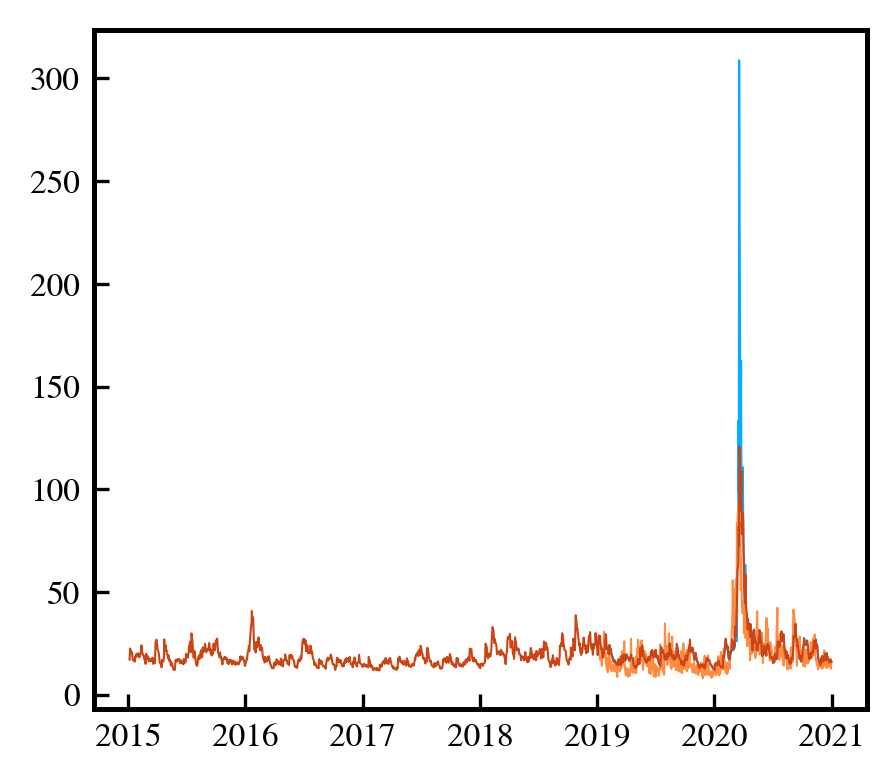

In [115]:
plt.plot(np.sqrt(252*predictor.evaluate()['Pred_t-GAS'])*np.sqrt(6.5/24),lw=0.5)
plt.plot(np.sqrt(252*predictor.evaluate()['True']),lw=0.5)
plt.plot(model1.return_vola()[0],np.sqrt(model1.return_vola()[1]*252)*np.sqrt(6.5/24),lw=0.5)
#plt.ylim(0,100)

In [ ]:
#model1_real = estimate_GAS(model='t-GAS', real=True)
#model2_real = estimate_GAS(model='GARCH', real=True)
#model3_real = estimate_GAS(model='skewed_t', real=True)

model1 = estimate_GAS(model='t-GAS')
model2 = estimate_GAS(model='GARCH')
model3 = estimate_GAS(model='skewed_t')

<ipython-input-78-95fffcf38462>:93: RuntimeWarning: overflow encountered in exp
  sigma2[t] = np.exp(params['mu'] + beta_part + alpha_part)
<ipython-input-78-95fffcf38462>:60: RuntimeWarning: overflow encountered in double_scalars
  b = 2*(beta-2)*np.sqrt(ht)*(1+(rho**2*(xhi**(-2*It)))/(beta-2))
<ipython-input-78-95fffcf38462>:88: RuntimeWarning: divide by zero encountered in log
  beta_part = params['phi']*np.log(sigma2[t-1])
<ipython-input-78-95fffcf38462>:90: RuntimeWarning: divide by zero encountered in log
  alpha_part = params['alpha']*(np.abs(self.RVOL[t-1]**2)-exp_abs)+params['gamma']*self.nabla(self.RVOL[t-1]**2,np.log(sigma2[t-1]), params)
<ipython-input-78-95fffcf38462>:52: RuntimeWarning: divide by zero encountered in double_scalars
  rho = s*((lagged_obs)/np.sqrt(ht)) + m
<ipython-input-78-95fffcf38462>:60: RuntimeWarning: invalid value encountered in double_scalars
  b = 2*(beta-2)*np.sqrt(ht)*(1+(rho**2*(xhi**(-2*It)))/(beta-2))


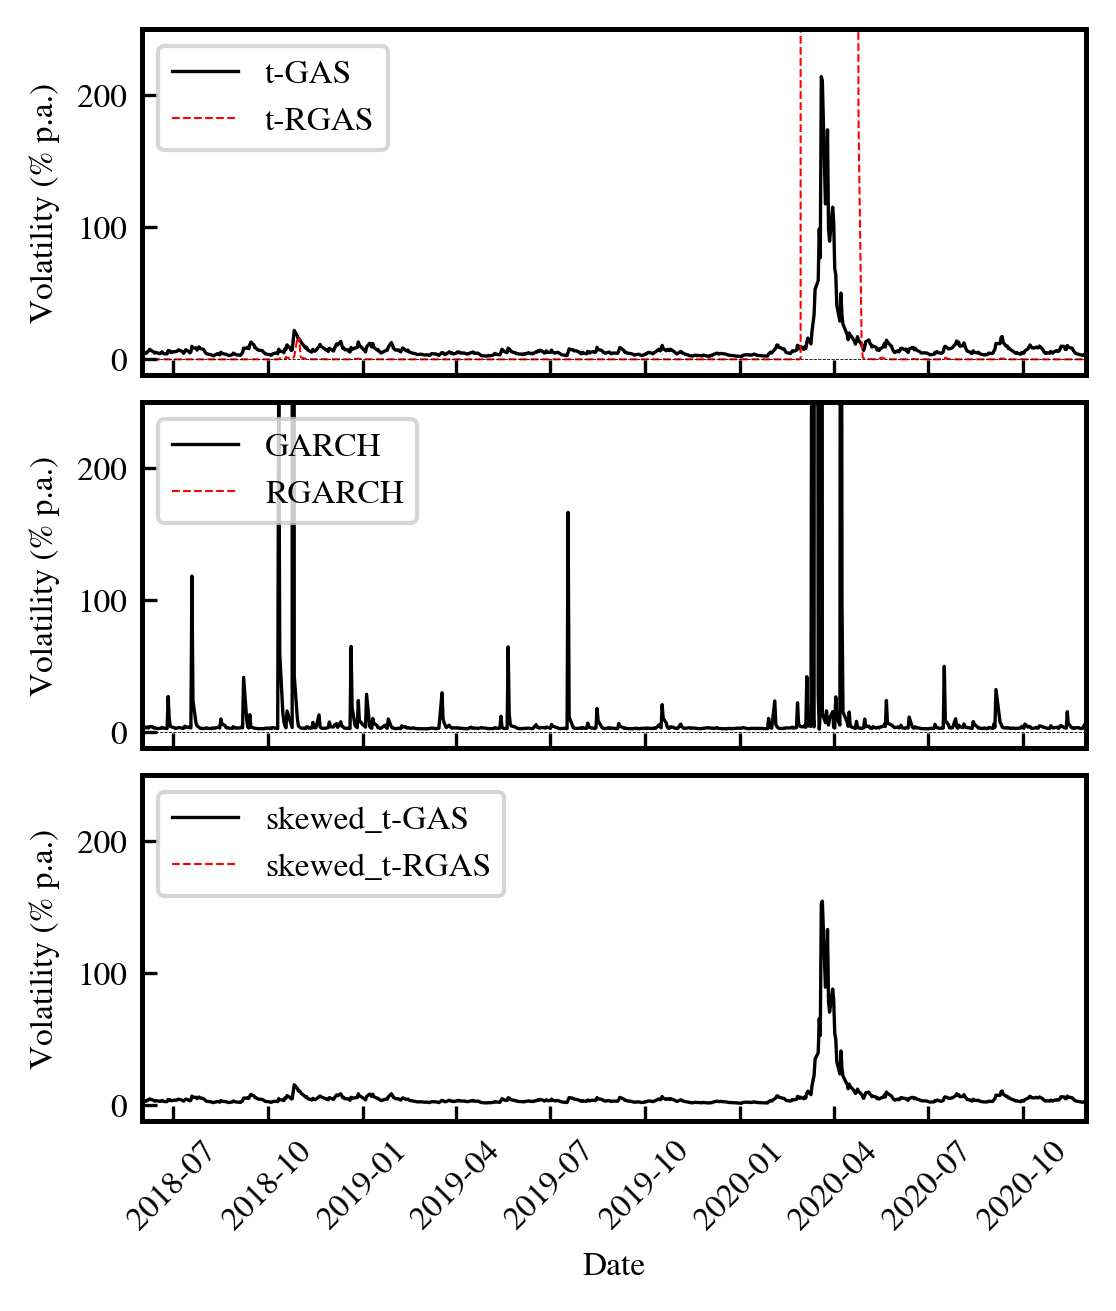

In [82]:
def plot_GASestimates():
    
    fig,[ax1,ax2,ax3]=plt.subplots(nrows=3, figsize=(3.321,4.2))
    ax1.plot(*model1.return_vola(),label='t-GAS',lw=0.8,color='black')
    ax2.plot(*model2.return_vola(),label='GARCH',lw=0.8,color='black')
    ax3.plot(*model3.return_vola(),label='skewed_t-GAS',lw=0.8,color='black')
    ax1.plot(*model1_real.return_vola(),label='t-RGAS',lw=0.5,color='red', ls='--')
    ax2.plot(*model2_real.return_vola(),label='RGARCH',lw=0.5,color='red', ls='--')
    ax3.plot(*model3_real.return_vola(),label='skewed_t-RGAS',lw=0.5,color='red', ls='--')
    ax1.set_xlim([datetime.date(2018, 6, 1), datetime.date(2020, 12, 1)])
    ax1.set_xticklabels(['']*len(ax1.get_xticks()))
    ax2.set_xlim([datetime.date(2018, 6, 1), datetime.date(2020, 12, 1)])
    ax2.set_xticklabels(['']*len(ax3.get_xticks()))
    ax3.set_xlim([datetime.date(2018, 6, 1), datetime.date(2020, 12, 1)])
    

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    ax1.set_ylabel('Volatility (% p.a.)')
    ax2.set_ylabel('Volatility (% p.a.)')
    ax3.set_ylabel('Volatility (% p.a.)')
    ax1.legend(frameon=True,loc='upper left')
    ax2.legend(frameon=True,loc='upper left')
    ax3.legend(frameon=True,loc='upper left')
    plt.tight_layout(pad=-0.4)
    ax1.set_ylim(-12,250)
    ax2.set_ylim(-12,250)
    ax3.set_ylim(-12,250)
    ax1.axhline(0,lw=0.2,ls='--',color='black')
    ax2.axhline(0,lw=0.2,ls='--',color='black')
    plt.savefig('GAS.pdf',bbox_inches='tight')
    plt.show()
plot_GASestimates()

In [ ]:
# Evaluate future predictions

In [276]:
def baseline_predict(x):
    """predict sigma_t for sigma_t+1 each time and evaluate the RMSE and MAE of it
       x is measures of realized volatility in the form of a dateframe"""
    # Get data for 2019 and 2020
    data_2019_2020 = pd.concat((x.loc['2019'],x.loc['2020']))
    # Predict latest value for each next sigma2
    data_2019_2020['predict_last'] = np.roll(data_2019_2020,1)
    # Or predict mean value for each sigma2
    data_2019_2020['predict_mean'] = np.mean(x.RealizedKernel)
    # Remove first since it is not relevant because of rolling
    data_2019_2020 = data_2019_2020.iloc[1:]
    # Obtain RMSE and MAE estimates
    RMSE_last = np.sqrt(mean_squared_error(data_2019_2020.RealizedKernel,data_2019_2020.predict_last))
    MAE_last  = mean_absolute_error(data_2019_2020.RealizedKernel,data_2019_2020.predict_last)
    RMSE_mean = np.sqrt(mean_squared_error(data_2019_2020.RealizedKernel,data_2019_2020.predict_mean))
    MAE_mean  = mean_absolute_error(data_2019_2020.RealizedKernel,data_2019_2020.predict_mean)

    return RMSE_last,MAE_last,RMSE_mean,MAE_mean
baseline_predict(np.sqrt(252*RK_values))

(6.244185408772259, 4.360478584809514, 11.963793459394662, 6.762887231197771)

In [82]:
params = pd.read_excel('../params.xls')
params['Parameter Estimate'] = params['Parameter Estimate'].astype(float)
params['tstat'] = params['tstat'].astype(float)

FileNotFoundError: [Errno 2] No such file or directory: '../params.xls'

In [294]:
params = params.set_index(['Model', 'Variable']).drop('DOF',axis=1)

In [ ]:
sig = params['tstat'].unstack().abs()>1.86
sig[sig] = '^*$'
sig = sig.replace(False,'$')

Variable,alpha1,alpha1min,alpha1plus,alpha2,alpha2min,alpha2plus,beta1,beta2,omega,phi1,phi2,theta
Model,,,,,,,,,,,,
"EGARCH(1,1)",0.0158,-,-,-,-,-,0.006089,-,0.0482,-,-,0.1677
"EGARCH(1,2)",0.0286,-,-,0.027,-,-,0.006232,-,0.0495,-,-,0.1735
"EGARCH(2,1)",0.0122,-,-,-,-,-,0.0592,0.0593,0.0195,-,-,0.1772
"GARCH(1,1)",0.0184,-,-,-,-,-,0.032,-,7.1333e-06,-,-,-
"GARCH(1,2)",0.0325,-,-,0.0339,-,-,0.0336,-,7.0737e-06,-,-,-
"GARCH(2,1)",0.0306,-,-,-,-,-,0.1951,0.1636,9.4372e-06,-,-,-
"GARCH(2,2)",0.0224,-,-,0.0888,-,-,0.9961,0.8142,3.38e-05,-,-,-
"QGARCH(1,1)",0.008614,-,-,-,-,-,0.002764,-,4.1072e-06,0.0143,-,-
"QGARCH(1,2)",0.0171,-,-,0.0139,-,-,0.003657,0.013,0.0,0.0214,-,-


In [317]:
combined = '$'+params['Parameter Estimate'].unstack().fillna('-').astype(str) +sig #+ r'$\pm$'+params['Standard Error'].unstack().fillna('-').astype(str)

In [318]:
combined.columns = [r'$\alpha_1$',r'$\alpha_1^{-}$',r'$\alpha_1^{+}$',r'$\alpha_2$',r'$\alpha_2^{-}$',r'$\alpha_2^{+}$',
                    r'$\beta_1$',r'$\beta_2$',r'$\omega$',r'$\phi_1$',r'$\phi_1$',r'$\theta$']

In [ ]:
combined=combined.replace('$-$$\\pm$-','-')

In [334]:
combined = combined[np.hstack((combined.columns[8],combined.columns[:8],combined.columns[9:]))]

In [335]:
print(combined.to_latex(escape=False))

\begin{tabular}{lllllllllllllll}
\toprule
{} &      $\omega$ &  $\alpha_1$ & $\alpha_1^{-}$ & $\alpha_1^{+}$ &  $\alpha_2$ & $\alpha_2^{-}$ & $\alpha_2^{+}$ &   $\beta_1$ &   $\beta_2$ &    $\phi_1$ &    $\phi_1$ &    $\phi_1$ &    $\phi_1$ &     $\theta$ \\
Model       &               &             &                &                &             &                &                &             &             &             &             &             &             &              \\
\midrule
EGARCH(1,1) &   $-0.2438^*$ &  $0.1126^*$ &            $-$ &            $-$ &         $-$ &            $-$ &            $-$ &  $0.9683^*$ &         $-$ &         $-$ &         $-$ &         $-$ &         $-$ &  $-0.9152^*$ \\
EGARCH(1,2) &   $-0.2473^*$ &  $0.0995^*$ &            $-$ &            $-$ &    $0.0124$ &            $-$ &            $-$ &  $0.9679^*$ &         $-$ &         $-$ &         $-$ &         $-$ &         $-$ &  $-0.9486^*$ \\
EGARCH(2,1) &   $-0.2299^*$ &  $0.1039^*$ &           

In [80]:
scores = pd.read_excel('./SAS_llikhood_AIC.xlsx').set_index('Model')#

In [354]:
scores.AIC.idxmin()

'TGARCH(1,2)'

In [353]:
print(scores.to_latex(bold_rows=True))

\begin{tabular}{lrr}
\toprule
{} &  LogLikelihood &        AIC \\
\textbf{Model      } &                &            \\
\midrule
\textbf{GARCH(1,1) } &     3872.06895 & -7738.1379 \\
\textbf{GARCH(1,2) } &     3872.06895 & -7738.1379 \\
\textbf{GARCH(2,1) } &     3872.72882 & -7743.4576 \\
\textbf{GARCH(2,2) } &     3872.79807 & -7737.5961 \\
\textbf{GARCH(2,3) } &     3826.28398 & -7650.5653 \\
\textbf{GARCH(3,2) } &     3877.11085 & -7748.2217 \\
\textbf{GARCH(3,3) } &     3877.13919 & -7746.2518 \\
\textbf{EGARCH(1,1)} &     3886.24378 & -7764.4876 \\
\textbf{EGARCH(1,2)} &     3886.30815 & -7762.6163 \\
\textbf{EGARCH(2,1)} &     3886.18014 & -7762.3603 \\
\textbf{TGARCH(1,1)} &     3882.80296 & -7757.6059 \\
\textbf{TGARCH(1,2)} &     3891.18486 & -7770.3697 \\
\textbf{TGARCH(2,1)} &     3882.80296 & -7755.6059 \\
\textbf{TGARCH(2,2)} &     3891.53825 & -7769.0765 \\
\textbf{QGARCH(1,1)} &     3879.51218 & -7751.0244 \\
\textbf{QGARCH(1,2)} &     3881.69526 & -7751.3905 \\
\textbf

In [81]:
params

NameError: name 'params' is not defined

In [499]:
def garch(params,p,q):
    h = np.zeros(len(logRVs))
    h[0:max(p,q)] = np.var(daily_returns)
    for t in range(max(p,q),len(h)):
        h[t] += params[0]
        for i in range(0,p):
            beta = params[1+q+i]
            h[t] += beta*h[t-i]
        for i in range(0,q):
            alpha = params[1+i]
            h[t] += alpha*(daily_returns.values.flatten()[t-i])**2
    h[h==0]=np.nan
    return np.sqrt(252*1e4*h)

def egarch():
    h = np.zeros(len(logRVs))
    earch0 = -0.2360
    earch1 = 0.1126
    egarch1 = 0.9697
    theta = -0.8808
    y=daily_returns.values.flatten()*100
    h[0] = np.exp(earch0+egarch1*np.log(np.std(y)))
    for t in range(1,len(h)):
        g = theta * y[t-1] + np.abs(y[t-1])-np.sqrt(2/np.pi)
        h[t] = np.exp(earch0 + earch1*g+egarch1*np.log(h[t-1]))
    #h[h==0]=np.nan
    return np.sqrt(252*h)
    
def qgarch():
    arch0=0.000664
    arch1=0.060074
    garch1=0.897607
    phi=-0.00172
    
    h = np.zeros(len(logRVs))
    y=daily_returns.values.flatten()*100
    h[0] = np.var(y)#
    for t in range(1,len(h)):
        h[t] = arch0 + arch1*y[t-1]**2 + garch1*h[t-1] +  phi*y[t-1]
    #h[h==0]=np.nan
    return np.sqrt(252*h)


def tgarch():
    intercept =0.000521 
    arch0 =-0.00581 
    arch1_plus =-0.1775
    arch1_minus =0.249302
    garch1 =-0.54367 

    h = np.zeros(len(logRVs))
    y=daily_returns.values.flatten()*100
    h[0] = np.var(y)#
    for t in range(1,len(h)):
        if y[t-1] < 0:
            h[t] = (arch0 + arch1_plus*y[t-1] + garch1*np.sqrt(h[t-1]) )**2
        else:
            h[t] = (arch0 + arch1_minus*y[t-1] + garch1*np.sqrt(h[t-1])  )**2
        
    #h[h==0]=np.nan
    return np.sqrt(252*h)




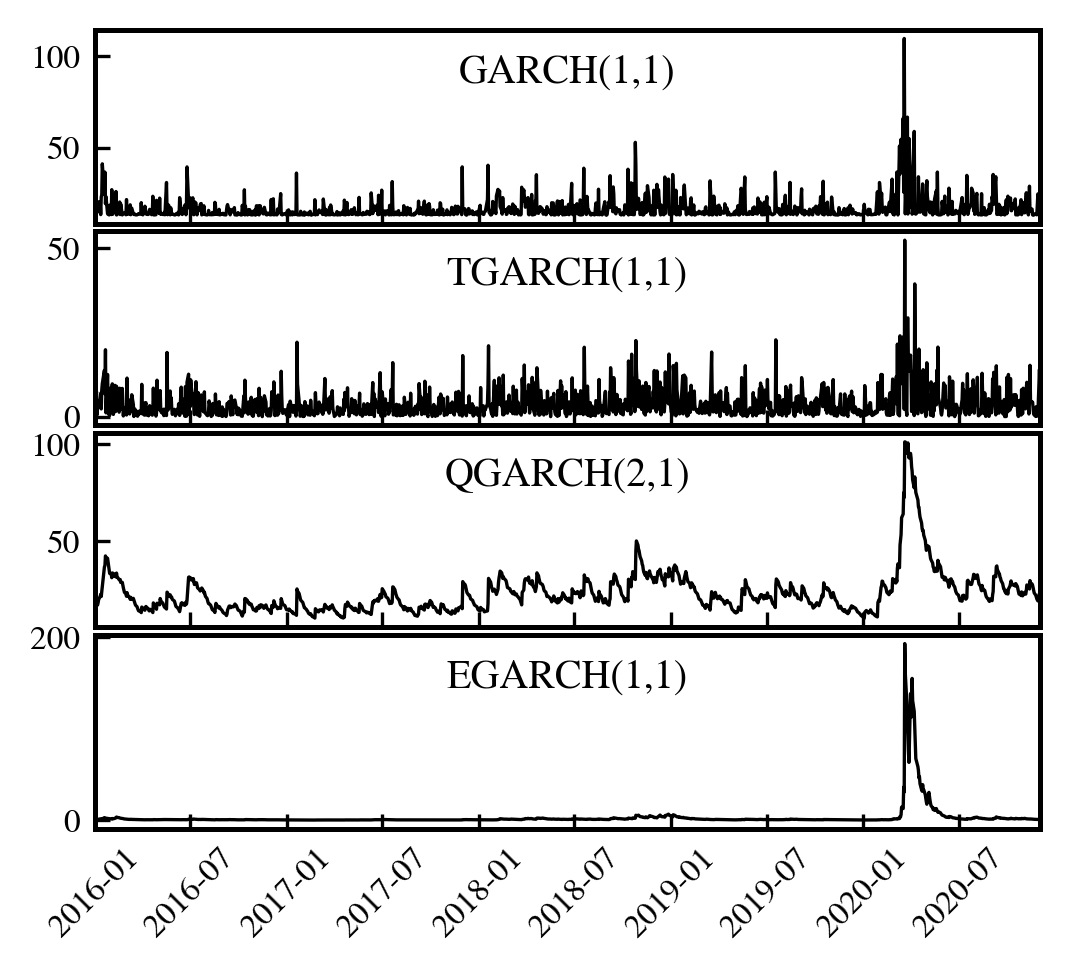

In [498]:
def plot_GARCHestimates():
    GARCH_time = daily_returns.index
    
    g11 = garch(params.loc['GARCH(1,1)']['Parameter Estimate'].values.flatten(),1,1)
    tg = tgarch()
    qg = qgarch()
    eg = egarch()
    
    fig,[ax1,ax2,ax3,ax4]=plt.subplots(nrows=4,sharex=True)
    ax1.plot(GARCH_time, g11,label='GARCH(3,3)',lw=0.8,color='black')
    ax2.plot(GARCH_time, tg,label='RealGARCH(3,3)',lw=0.8,color='black')
    ax3.plot(GARCH_time, qg,label='GARCH(3,3)',lw=0.8,color='black')
    ax4.plot(GARCH_time, eg,label='RealGARCH(3,3)',lw=0.8,color='black')
    
    ax1.set_xlim([datetime.date(2016, 1, 1), datetime.date(2020, 12, 1)])
    ax2.set_xlim([datetime.date(2016, 1, 1), datetime.date(2020, 12, 1)])
    ax3.set_xlim([datetime.date(2016, 1, 1), datetime.date(2020, 12, 1)])
    ax4.set_xlim([datetime.date(2016, 1, 1), datetime.date(2020, 12, 1)])
    
    ax1.set_title('GARCH(1,1)',y=0.6)
    ax2.set_title('TGARCH(1,1)',y=0.6)
    ax3.set_title('QGARCH(2,1)',y=0.6)
    ax4.set_title('EGARCH(1,1)',y=0.6)
    
    plt.xticks(rotation=45)
    #for ax in [ax1,ax2,ax3,ax4]:
    #    ax.set_ylim(1,125)
    plt.tight_layout(pad=-0.2)
    
    plt.savefig('Garch_plots.pdf',bbox_inches='tight')
    plt.show()
    return 
plot_GARCHestimates()

In [178]:
from scipy.optimize import minimize
from scipy.optimize import approx_fprime
class special_GARCH():
    def __init__(self,model,p,q):
        self.options = {'eps':1e-09,
                      'disp': True,
                      'maxiter':2000}
        self.p,self.q = p,q

        self.model = model # i.e. E for EGARCH
        self.closingreturns = daily_returns.values.flatten()*100
        self.n = len(self.closingreturns)
        self.__RVOL__()
        # Call fit of GARCH
        self.fit_garch(self.closingreturns)
        return
    
    def __RVOL__(self):
        """Obtain realized volatilities from highfreq data"""
        # Convert to logprices
        df['LOGPRICE'] = np.log(df.PRICE)
        # Convert to returns
        df['DELTALOG'] = df.LOGPRICE.diff()*100
        # Only intraday, no interday returns since these screw up the results
        newday = pd.Series(df.index).diff()[pd.Series(df.index).diff()>pd.Timedelta('1h')].index
        df.loc[df.iloc[newday].index,'DELTALOG']=np.nan
        # Take sum of squared returns within one day and resample to annual volatility
        self.RVOL = np.sqrt((df[['DELTALOG']]**2).resample('1D').sum())
        self.RVOL = self.RVOL[self.RVOL>0]
        # Daily returns do not have first day and no weekends, so drop them
        self.RVOL = self.RVOL.dropna().values.flatten()[1:]
    
    def EGARCH(self, y, params):
        ft = np.zeros(self.n)
        
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            ft[i] = np.exp(params['mu']+params['alpha']*np.log(np.std(y)))
        # Iterate through times
        for t in range(max(self.p,self.q),self.n):
            theta_part = 0
            beta_part  = 0
            # Obtain beta part (lagged sigma2)
            for i in range(0,self.p):
                name = 'beta' + str(i)
                beta_part = beta_part+params[name]*np.log(ft[t-i-1])
            # Obtain alpha part (lagged returns)
            for i in range(0,self.q):
                name = 'theta' + str(i)
                if self.model == 'GARCH':
                    theta_part = theta_part+params[name]*y[t-i-1]
                    
            # Combine in ft[t]
            g = theta_part + np.abs(y[t-1])/np.sqrt(ft[t-1])-np.sqrt(2/np.pi)
            ft[t] = np.exp(params['mu'] + params['alpha']*g + beta_part)
        
        return ft
    
    def TGARCH(self, y, params):
        ft = np.zeros(self.n)

        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            ft[i] = np.var(y)
        
        for t in range(max(self.p,self.q),self.n):
            alpha_part = 0
            beta_part = 0
            for i in range(0, self.p):
                alphaP = 'alphaP' + str(i)
                alphaM = 'alphaM' + str(i)
                alpha_part = alpha_part + params[alphaP]*(np.abs(y[t-1]) - params[alphaM]*y[t-1]) 
            for i in range(0, self.q):
                beta = 'beta' + str(i)
                beta_part = beta_part + params[beta]*np.sqrt(ft[t-1])
            ft[t] = (params['mu'] + alpha_part + beta_part)**2
            
        return ft   
    
    def QGARCH(self, y, params):
        ft = np.zeros(self.n)
        
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            ft[i] = np.var(y)
            
        for t in range(max(self.p,self.q),self.n):
            alpha_part = 0
            beta_part = 0
            for i in range(0, self.p):
                alpha = 'alpha' + str(i)
                alpha_part = alpha_part + params[alpha]*y[t-1]**2 
            for i in range(0, self.q):
                beta = 'beta' + str(i)
                beta_part = beta_part + params[beta]*ft[t-1]
                
            ft[t] = params['mu'] + alpha_part + beta_part + params['phi']*y[t-1]
        
        return ft
    
    def MGARCH(self, y, params):
        ft = np.zeros(self.n)
        
        # fill first values with sample variance
        for i in range(0,max(self.p,self.q)+1):
            ft[i] = np.var(y)
        
        # first value for at : at = y - omega - c*ft
#         at = ft[0]
        for t in range(max(self.p,self.q),self.n):
            alpha_part = 0
            beta_part = 0
            at = y[t-1] - params['omega'] - params['c']*ft[t-1] 
            for i in range(0, self.p):
                alpha = 'alpha' + str(i)
                alpha_part = alpha_part + params[alpha]*at**2 
            for i in range(0, self.q):
                beta = 'beta' + str(i)
                beta_part = beta_part + params[beta]*ft[t-1]
                
            ft[t] = params['mu'] + alpha_part + beta_part
        
        return ft
        
    
    def __llik_fun_GARCH__(self,params,estimate=True):
        x = self.closingreturns
          
        params = dict(zip(self.parameter_keys, params))  
        
        if self.model == 'E': # E-GARCH
            sigma2 = self.EGARCH(x, params)
            
        elif self.model == 'T': # T-GARCH
            sigma2 = self.TGARCH(x, params)
        
        elif self.model == 'Q': # Q-GARCH
            sigma2 = self.QGARCH(x, params)
            
        elif self.model == 'M': # M-GARCH
            sigma2 = self.MGARCH(x, params)
         
        # Derive likelihood
        if estimate:
            L = -0.5*np.log(2*np.pi) - 0.5*np.log(sigma2) - 0.5*x**2/sigma2

            llik = np.mean(L)

            return -1*llik
        else:
            return sigma2
    
    
    def fit_garch(self,x):
        # Initialize values

        if self.model == 'E': # E-GARCH
            self.parameter_keys = (['mu'] + ['alpha']) 
            for i in range(0, self.q):
                theta = 'theta' + str(i)
                self.parameter_keys.append(theta) 
            for i in range(0, self.p):
                beta = 'beta' + str(i)
                self.parameter_keys.append(beta)

            par_ini = np.random.rand(len(self.parameter_keys))
            bounds_model = (len(self.parameter_keys)-self.p)*[(-np.infty,np.infty)] + [(-1,1)]*(self.p)
        
        elif self.model == 'T':
            self.parameter_keys = (['mu'])
            for i in range(0, self.q):
                alphaP = 'alphaP' + str(i)
                alphaM = 'alphaM' + str(i)
                self.parameter_keys.append(alphaP)
                self.parameter_keys.append(alphaM)
            for i in range(0, self.p):
                beta = 'beta' + str(i)
                self.parameter_keys.append(beta)
                
            par_ini = np.random.rand(len(self.parameter_keys))
            bounds_model = (len(self.parameter_keys)-self.p)*[(-np.infty,np.infty)] + [(-1,1)]*self.p
        
        elif self.model == 'Q':
            self.parameter_keys = (['mu'] + ['phi'])
            for i in range(0, self.q):
                alpha = 'alpha' + str(i)
                self.parameter_keys.append(alpha)
            for i in range(0, self.p):
                beta = 'beta' + str(i)
                self.parameter_keys.append(beta)
                
            par_ini = np.random.rand(len(self.parameter_keys))
            bounds_model = (len(self.parameter_keys)-self.p)*[(-np.infty,np.infty)] + [(-1,1)]*self.p   
            
        elif self.model == 'M':
            self.parameter_keys = (['c'] + ['mu'] + ['omega'])
            for i in range(0, self.q):
                alpha = 'alpha' + str(i)
                self.parameter_keys.append(alpha)
            for i in range(0, self.p):
                beta = 'beta' + str(i)
                self.parameter_keys.append(beta)
                
            par_ini = np.random.rand(len(self.parameter_keys))
            bounds_model = [(-1,1)] + (len(self.parameter_keys)-self.p-1)*[(-np.infty,np.infty)] + [(-1,1)]*self.p  
                       
        Lprime = lambda x: approx_fprime(x, self.__llik_fun_GARCH__, 0.01)        
        est = minimize(self.__llik_fun_GARCH__, x0=par_ini,
                       options = self.options,
                       method = 'Newton-CG',
                       jac = Lprime
                       #bounds =  bounds_model
                      )
        llikhood = -est.fun
        self.AIC = 2*(len(par_ini))-2*llikhood
        self.BIC = (len(par_ini)) * np.log(len(self.closingreturns)) - 2*llikhood
        self.llik_opt = llikhood
        
        self.estimates = est.x
        
    def return_vola(self):
        sigma2 = self.__llik_fun_GARCH__(self.estimates,estimate=False)
        return daily_returns.index,np.sqrt(sigma2)*np.sqrt(252)
    
    def return_llik_AIC_BIC(self):
        return self.AIC,self.BIC,self.llik_opt
    
GARCH = special_GARCH(model='M', p=1, q=1)
GARCH_time, GARCH_vola = GARCH.return_vola()

         Current function value: 2.037721
         Iterations: 8
         Function evaluations: 30
         Gradient evaluations: 53
         Hessian evaluations: 0


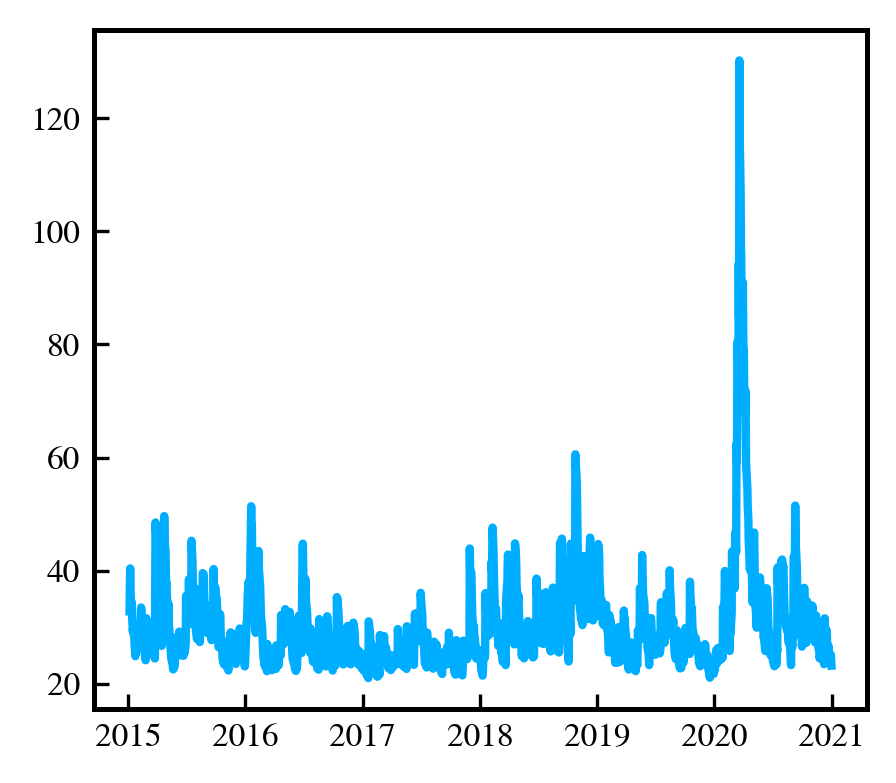

In [179]:
plt.plot(GARCH_time, GARCH_vola)